# Labolatorium nr 1

## Import bibliotek oraz ich konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

## Zadanie 1 - Sumowanie liczb pojedynczej precyzji

### Stałe

In [2]:
N = int(1e7)
v = np.float32(0.53125)
v_64 = np.float64(0.53125)
expected_sum = 5312500.0

### Algorytm 1 - Proste sumowanie

Suma: 5030840.5
Błąd bezwzględny: 281659.5
Błąd względny: 5.301825882352941%


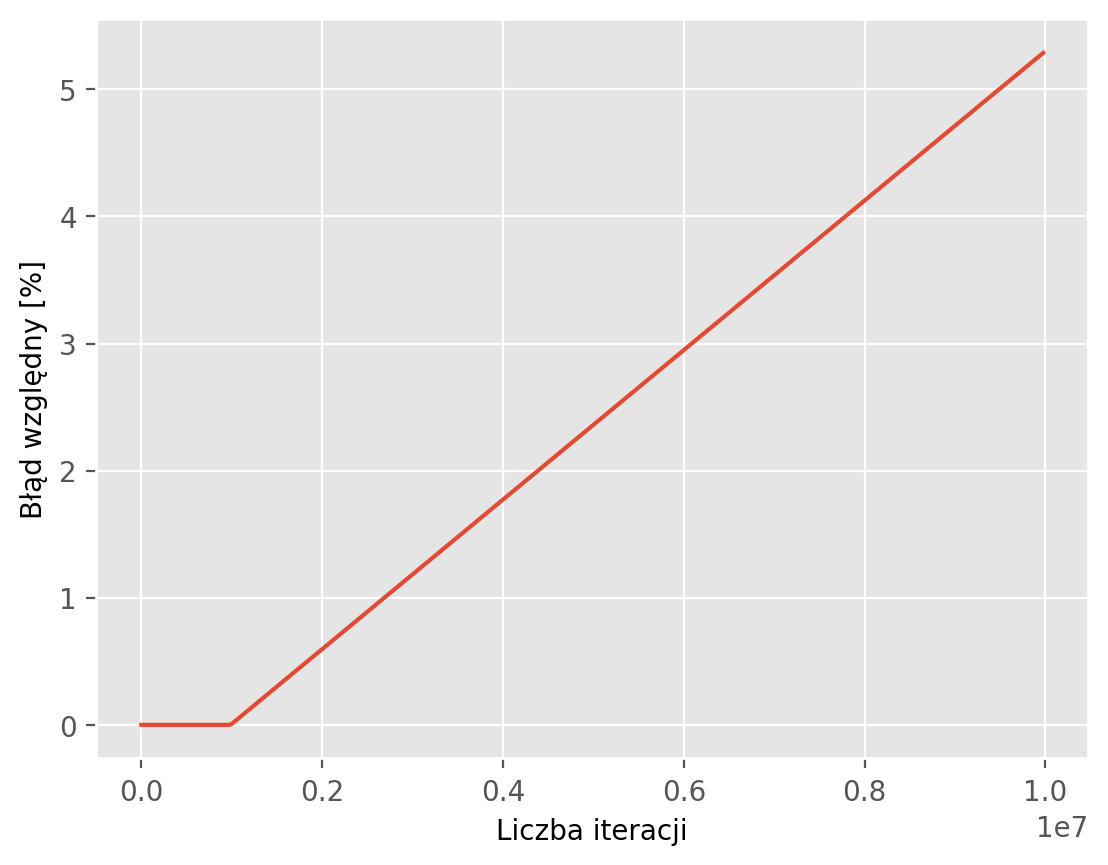

In [3]:
single_prec_result = np.float32(0)
double_prec_result = np.float64(0)
error_list = []

time_start = time.time()
for i in range(N):
    if i % 25000 == 0:
        error_list.append(abs(double_prec_result - single_prec_result) / expected_sum * 100)
    single_prec_result += v
    double_prec_result += v_64

algorithm_1_execution_time = time.time() - time_start

print(f"Suma: {single_prec_result}")
print(f"Błąd bezwzględny: {abs(expected_sum - single_prec_result)}")
print(f"Błąd względny: {abs(expected_sum - single_prec_result) / expected_sum * 100}%")

# Wykres błędu względnego
plt.plot(np.arange(0,N, 25000), error_list)
plt.xlabel("Liczba iteracji")
plt.ylabel("Błąd względny [%]")
plt.show()

Dlaczego błąd względny jest tak duży?

Jest to spowodowane tym, że podczas prostego sumowania, błędy zaokrągleń są kumulowane (z małej liczby robimy coraz to większą, jednocześnie dodając stosunkowo małe liczby co powoduje błędy, bo mantysa już nie ma gdzie trzymać nowych danych i liczby są zaokrąglane (lub po prostu obcinana jest część, która się nie mieści)). Zatem im więcej liczb dodajemy "szeregowo", tym większy jest błąd.

Analizując powyższy wykres można zauważyć, że błąd względny rośnie w sposób liniowy. Dlatego można powiedzieć, że błąd względny jest proporcjonalny do liczby dodawanych liczb.

### Algorytm 2 - Sumowanie rekurencyjne

In [4]:
def recursive_sum(i, j, value):
    if i == j:
        return value
    else:
        return recursive_sum(i, (i+j)//2, value) + recursive_sum((i+j)//2 + 1, j, value)

time_start = time.time()
single_prec_result = recursive_sum(0, N-1, v)
algorithm_2_execution_time = time.time() - time_start

print(f"Suma: {single_prec_result}")
print(f"Błąd bezwzględny: {abs(expected_sum - single_prec_result)}")
print(f"Błąd względny: {abs(expected_sum - single_prec_result) / expected_sum * 100}%")


Suma: 5312500.0
Błąd bezwzględny: 0.0
Błąd względny: 0.0%


Dlaczego błąd względny znacznie się zmniejszył?

Błąd względny znacznie się zmniejszył, ponieważ w algorytmie rekurencyjnym, dodawane liczby do siebie nie są tak bardzo rozbieżne wielkościowo, co powoduje, że błędy zaokrągleń są mniejsze. 

### Czas wykonania algorytmów

In [5]:
print(f"Czas wykonania algorytmu 1: {algorithm_1_execution_time}s")
print(f"Czas wykonania algorytmu 2: {algorithm_2_execution_time}s")

Czas wykonania algorytmu 1: 1.2323031425476074s
Czas wykonania algorytmu 2: 1.6495168209075928s


### Przykładowe dane wejściowe, gdy algorytm rekruencyjny zwraca niezerowy błąd

In [6]:
single_prec_result = recursive_sum(0, N-1, np.float32(0.41231))
print(f"Suma: {single_prec_result}")
print(f"Błąd bezwzględny: {abs(0.41231 * N - single_prec_result)}")

Suma: 4123100.25
Błąd bezwzględny: 0.25


## Zadanie 2 - Algorytm Kahana

In [7]:
def kahan_sum(v, N):
    sum = np.float32(0)
    err = np.float32(0) # This accumulates number which has been lost due to rounding

    for _ in range(N):
        y = v - err # This is the number which is added to sum minus the accumulated error
        t = sum + y # DANGEROUS PART! This can floor the number and cause loss of precision
        err = (t - sum) - y # Substract new sum - old sum and the number which was added to sum -> that's how we obtain the new error
        sum = t

    return sum

time_start = time.time()
single_prec_result = kahan_sum(v, N)
algorithm_3_execution_time = time.time() - time_start

print(f"Suma: {single_prec_result}")
print(f"Błąd bezwzględny: {abs(expected_sum - single_prec_result)}")
print(f"Błąd względny: {abs(expected_sum - single_prec_result) / expected_sum * 100}%")    

Suma: 5312500.0
Błąd bezwzględny: 0.0
Błąd względny: 0.0%


Dlaczego powyższy algorytm ma lepsze własności numeryczne? 

Jest to spowodowane spamiętywaniem błędu podczas sumowania. Gdy dodajemy nową liczbę do całkowitej sumy, to nowa suma utraci część cyfr po przecinku. Dlatego, żeby zobaczyć ile straciliśmy, tworzymy zmienną err, która przechowuje błąd (czyli od nowej sumy odejmujemy starą sumę oraz dodaną liczbę). Następnie zostawiamy naszą sumę z błędem, natomiast w następnej iteracji wprowadzana jest poprawka do nowo dodawanej liczby.

### Porównanie czasu wykonania algorytmów nr 2 i 3

In [8]:
print(f"Czas wykonania algorytmu 2: {algorithm_2_execution_time}s")
print(f"Czas wykonania algorytmu 3: {algorithm_3_execution_time}s")

Czas wykonania algorytmu 2: 1.6495168209075928s
Czas wykonania algorytmu 3: 1.1095459461212158s


## Zadanie 3 - Sumy częściowe

### Funkcja dzeta Riemanna

In [9]:
def riemann_function_float32(s, n, reverse=False):
    loop_range = range(1, n+1) if not reverse else range(n, 0, -1)

    value = np.float32(0)
    for k in loop_range:
        value += np.float32(1) / np.float32(k**s)

    return value

def riemann_function_float64(s, n, reverse=False):
    loop_range = range(1, n+1) if not reverse else range(n, 0, -1)

    value = np.float64(0)
    for k in loop_range:
        value += np.float64(1) / np.float64(k**s)

    return value

### Funkcja eta Dirichleta

In [10]:
def dirichlet_function_float32(s, n, reverse=False):
    loop_range = range(1, n+1) if not reverse else range(n, 0, -1)

    value = np.float32(0)
    for k in loop_range:
        value += np.float32((-1)**(k-1)) / np.float32(k**s)

    return value

def dirichlet_function_float64(s, n, reverse=False):
    loop_range = range(1, n+1) if not reverse else range(n, 0, -1)

    value = np.float64(0)
    for k in loop_range:
        value += np.float64((-1)**(k-1)) / np.float64(k**s)

    return value

### Porównanie wyników sumowania w przód oraz w tył

In [11]:
s_values = [2, 3.6667, 5, 7.2, 10]
n_values = [50, 100, 200, 500, 1000]

In [12]:
riemann_results_float64_forward = [riemann_function_float64(s, n) for s in s_values for n in n_values]
riemann_results_float64_backward = [riemann_function_float64(s, n, True) for s in s_values for n in n_values]

dirichlet_results_float64_forward = [dirichlet_function_float64(s, n) for s in s_values for n in n_values]
dirichlet_results_float64_backward = [dirichlet_function_float64(s, n, True) for s in s_values for n in n_values]

riemann_results_float32_forward = [riemann_function_float32(s, n) for s in s_values for n in n_values]
riemann_results_float32_forward_rel_error = [abs(riemann_results_float64_forward[i] - riemann_results_float32_forward[i]) / riemann_results_float64_forward[i] * 100 for i in range(len(riemann_results_float64_forward))]

riemann_results_float32_backward = [riemann_function_float32(s, n, True) for s in s_values for n in n_values]
riemann_results_float32_backward_rel_error = [abs(riemann_results_float64_backward[i] - riemann_results_float32_backward[i]) / riemann_results_float64_backward[i] * 100 for i in range(len(riemann_results_float64_backward))]

dirichlet_results_float32_forward = [dirichlet_function_float32(s, n) for s in s_values for n in n_values]
dirichlet_results_float32_forward_rel_error = [abs(dirichlet_results_float64_forward[i] - dirichlet_results_float32_forward[i]) / dirichlet_results_float64_forward[i] * 100 for i in range(len(dirichlet_results_float64_forward))]

dirichlet_results_float32_backward = [dirichlet_function_float32(s, n, True) for s in s_values for n in n_values]
dirichlet_results_float32_backward_rel_error = [abs(dirichlet_results_float64_backward[i] - dirichlet_results_float32_backward[i]) / dirichlet_results_float64_backward[i] * 100 for i in range(len(dirichlet_results_float64_backward))]

In [13]:
df = pd.DataFrame(
    { "forward sum": riemann_results_float32_forward,
     "forward sum error [%]": riemann_results_float32_forward_rel_error,
     "backward sum": riemann_results_float32_backward,
        "backward sum error [%]": riemann_results_float32_backward_rel_error,
        "is result equal": [riemann_results_float32_forward[i] == riemann_results_float32_backward[i] for i in range(len(riemann_results_float32_forward))],
        "is result equal float64": [riemann_results_float64_forward[i] == riemann_results_float64_backward[i] for i in range(len(riemann_results_float64_forward))],
        "winning method": ["forward" if riemann_results_float32_forward_rel_error[i] < riemann_results_float32_backward_rel_error[i]  else "backward" for i in range(len(riemann_results_float32_forward_rel_error))],
        "error diff": [abs(riemann_results_float32_forward_rel_error[i] - riemann_results_float32_backward_rel_error[i]) for i in range(len(riemann_results_float32_forward_rel_error))]
     }, index=pd.MultiIndex.from_tuples([(s, n) for s in s_values for n in n_values], names=["s", "n"]))

df

forward sum  forward sum error [%]  backward sum  \
s       n                                                        
2.0000  50       1.625133           1.136746e-05      1.625133   
        100      1.634984           7.109157e-06      1.634984   
        200      1.639947           9.337345e-06      1.639946   
        500      1.642936           4.517988e-06      1.642936   
        1000     1.643935           1.698625e-05      1.643934   
3.6667  50       1.109399           2.859653e-05      1.109400   
        100      1.109409           1.625393e-05      1.109409   
        200      1.109409           1.465025e-04      1.109410   
        500      1.109409           1.689027e-04      1.109411   
        1000     1.109409           1.707053e-04      1.109411   
5.0000  50       1.036927           2.460081e-05      1.036928   
        100      1.036927           2.807031e-05      1.036928   
        200      1.036927           2.829170e-05      1.036928   
        500      1.036927           2.830624e-05      1.036928   
        1000     1.036927           2.830660e-05      1.036928   
7.2000  50       1.007228           7.198787e-07      1.007228   
        100      1.007228           7.203128e-07      1.007228   
        200      1.007228           7.203188e-07      1.007228   
        500      1.007228           7.203188e-07      1.007228   
        1000     1.007228           7.203188e-07      1.007228   
10.0000 50       1.000995           1.201315e-06      1.000995   
        100      1.000995           1.201315e-06      1.000995   
        200      1.000995           1.201315e-06      1.000995   
        500      1.000995           1.201315e-06      1.000995   
        1000     1.000995           1.201315e-06      1.000995   

              backward sum error [%]  is result equal  \
s       n                                               
2.0000  50              3.303254e-06            False   
        100             1.820033e-07            False   
        200             5.200848e-06            False   
        500             4.517989e-06             True   
        1000            4.768137e-06            False   
3.6667  50              3.639629e-06            False   
        100             5.236671e-06            False   
        200             3.931501e-06            False   
        500             3.021804e-06            False   
        1000            1.219199e-06            False   
5.0000  50              1.608018e-06            False   
        100             5.077521e-06            False   
        200             5.298918e-06            False   
        500             5.313452e-06            False   
        1000            5.313812e-06            False   
7.2000  50              7.198788e-07             True   
        100             7.203129e-07             True   
        200             7.203190e-07             True   
        500             7.203191e-07             True   
        1000            7.203191e-07             True   
10.0000 50              1.201315e-06             True   
        100             1.201315e-06             True   
        200             1.201315e-06             True   
        500             1.201315e-06             True   
        1000            1.201315e-06             True   

              is result equal float64 winning method    error diff  
s       n                                                           
2.0000  50                      False       backward  8.064207e-06  
        100                     False       backward  6.927153e-06  
        200                     False       backward  4.136497e-06  
        500                     False        forward  1.351511e-14  
        1000                    False       backward  1.221811e-05  
3.6667  50                      False       backward  2.495690e-05  
        100                     False       backward  1.101726e-05  
        200                     False       backward  1.425710e-04  
 

Pomimo, że kolejność w dodawaniu liczb nie jest istotna, to analizując powyższe wyniki możemy zauważyć, że algorytm zwrócił różne wyniki dla sumowania w przód i w tył. Jest to spowodowane własnością dodawania zmiennopozycyjnego:

$$ fl(a+b) = fl(b+a) $$ 
ale
$$ fl((a+b) + c) \neq fl(a+(b+c)) $$

Dla funkcji dzeta Riemanna, zazwyczaj mniejszy błąd względny, względem obliczeń dla podwójnej precyzji, był dla sumowania w tył. Jedynym przypadkiem kiedy to sumowanie w przód było lepsze, są obliczenia dla parametru $s=7.2$, jednakże różnica pomiędzy błędami względnymi dla obu metod jest niewielka. Dla wszystkich błędów względnych różnice pomiędzy metodami sumowanie są niewielkie, jednakże najmniejsze różnice pomiędzy błędami względnymi dla obu metod, są dla parametru $s=10$. Dla $s \in \{7.2, 10\}$ wyniki sumowań były takie same, ze względu na zmniejszoną precyzję obliczeń. Dla większej precyzji obliczeń, wyniki sumowania w przód i w tył były różne.

In [14]:
df = pd.DataFrame(
    { "forward sum": dirichlet_results_float32_forward,
     "forward sum error [%]": dirichlet_results_float32_forward_rel_error,
     "backward sum": dirichlet_results_float32_backward,
        "backward sum error [%]": dirichlet_results_float32_backward_rel_error,
        "is result equal": [dirichlet_results_float32_forward[i] == dirichlet_results_float32_backward[i] for i in range(len(dirichlet_results_float32_forward))],
         "is result equal float64": [dirichlet_results_float64_forward[i] == dirichlet_results_float64_backward[i] for i in range(len(dirichlet_results_float64_forward))],
        "winning method": ["forward" if dirichlet_results_float32_forward_rel_error[i] < dirichlet_results_float32_backward_rel_error[i]  else "backward" for i in range(len(dirichlet_results_float32_forward_rel_error))],
        "error diff": [abs(dirichlet_results_float32_forward_rel_error[i] - dirichlet_results_float32_backward_rel_error[i]) for i in range(len(dirichlet_results_float32_forward_rel_error))]
     }, index=pd.MultiIndex.from_tuples([(s, n) for s in s_values for n in n_values], names=["s", "n"]))

df

forward sum  forward sum error [%]  backward sum  \
s       n                                                        
2.0000  50       0.822271               0.000005      0.822271   
        100      0.822417               0.000004      0.822417   
        200      0.822455               0.000012      0.822455   
        500      0.822465               0.000039      0.822465   
        1000     0.822467               0.000038      0.822467   
3.6667  50       0.934693               0.000004      0.934693   
        100      0.934693               0.000005      0.934693   
        200      0.934693               0.000007      0.934693   
        500      0.934693               0.000007      0.934693   
        1000     0.934693               0.000007      0.934693   
5.0000  50       0.972120               0.000004      0.972120   
        100      0.972120               0.000004      0.972120   
        200      0.972120               0.000004      0.972120   
        500      0.972120               0.000004      0.972120   
        1000     0.972120               0.000004      0.972120   
7.2000  50       0.993527               0.000005      0.993527   
        100      0.993527               0.000005      0.993527   
        200      0.993527               0.000005      0.993527   
        500      0.993527               0.000005      0.993527   
        1000     0.993527               0.000005      0.993527   
10.0000 50       0.999040               0.000002      0.999040   
        100      0.999040               0.000002      0.999040   
        200      0.999040               0.000002      0.999040   
        500      0.999040               0.000002      0.999040   
        1000     0.999040               0.000002      0.999040   

              backward sum error [%]  is result equal  \
s       n                                               
2.0000  50              2.091360e-06            False   
        100             4.345632e-06             True   
        200             2.942243e-06            False   
        500             3.005273e-06            False   
        1000            2.229079e-06            False   
3.6667  50              4.069521e-06             True   
        100             1.641902e-06            False   
        200             6.014667e-07            False   
        500             7.883932e-07            False   
        1000            7.946263e-07            False   
5.0000  50              2.091761e-06            False   
        100             2.243117e-06            False   
        200             2.247973e-06            False   
        500             2.248130e-06            False   
        1000            2.248132e-06            False   
7.2000  50              5.515009e-07            False   
        100             5.515281e-07            False   
        200             5.515283e-07            False   
        500             5.515283e-07            False   
        1000            5.515283e-07            False   
10.0000 50              2.317808e-06             True   
        100             2.317808e-06             True   
        200             2.317808e-06             True   
        500             2.317808e-06             True   
        1000            2.317808e-06             True   

              is result equal float64 winning method    error diff  
s       n                                                           
2.0000  50                      False       backward  3.066064e-06  
        100                     False       backward  5.399802e-14  
        200                     False       backward  8.609845e-06  
        500                     False       backward  3.623537e-05  
        1000                    False       backward  3.623530e-05  
3.6667  50                      False       backward  3.563383e-14  
        100                     False       backward  3.093116e-06  
        200                     False       backward  6.376920e-06  
 

Analogicznie dla funkcji eta Dirichleta, zazwyczaj mniejszy błąd względny, względem obliczeń dla podwójnej precyzji, był dla sumowania w tył. Jedynym przypadkiem kiedy to sumowanie w tył było lepsze, są obliczenia dla parametru $s=7.2$. Dla wszystkich obliczeń różnice w błędach względnych dla obu metod są niewielkie, jednakże najmniejsze różnice pomiędzy błędami względnymi dla obu metod, są dla parametru $s=10$. Dla $s=10$ wyniki sumowań były takie same, ze względu na zmniejszoną precyzję obliczeń. Dla większej precyzji obliczeń, wyniki sumowania w przód i w tył były różne.

## Zadanie 4 - błędy zaokrągleń i odwzorowanie logistyczne

### Diagram bifurkacyjny

In [15]:
x_values = [0.00000001, 0.123214, 0.2137, 0.36667, 0.5, 0.72, 0.9, 0.95, 0.9999, 0.9999999, 0.99999999999999]

def logistic_function(r, x):
    return r * x * (1 - x)

def logistic_function_float32(r, x):
    return np.float32(r) * np.float32(x) * np.float32((1 - x))

In [16]:
def draw_diagram(x_i, r_range, n=1000):
    plt.title(f"Diagram bifurkacji dla x_n = {x_i}")

    r_values = []
    x_values = []
    for r in r_range:
        x = x_i
        for i in range(n):
            # Create vector of x values for given r
            x = logistic_function(r, x)

            if i >= n-100: # Draw only last 100 values
                r_values.append(r)
                x_values.append(x)

    plt.plot(r_values, x_values, ',k' ,alpha=0.25)
    plt.xlabel('r')
    plt.ylabel('x')
    plt.show()


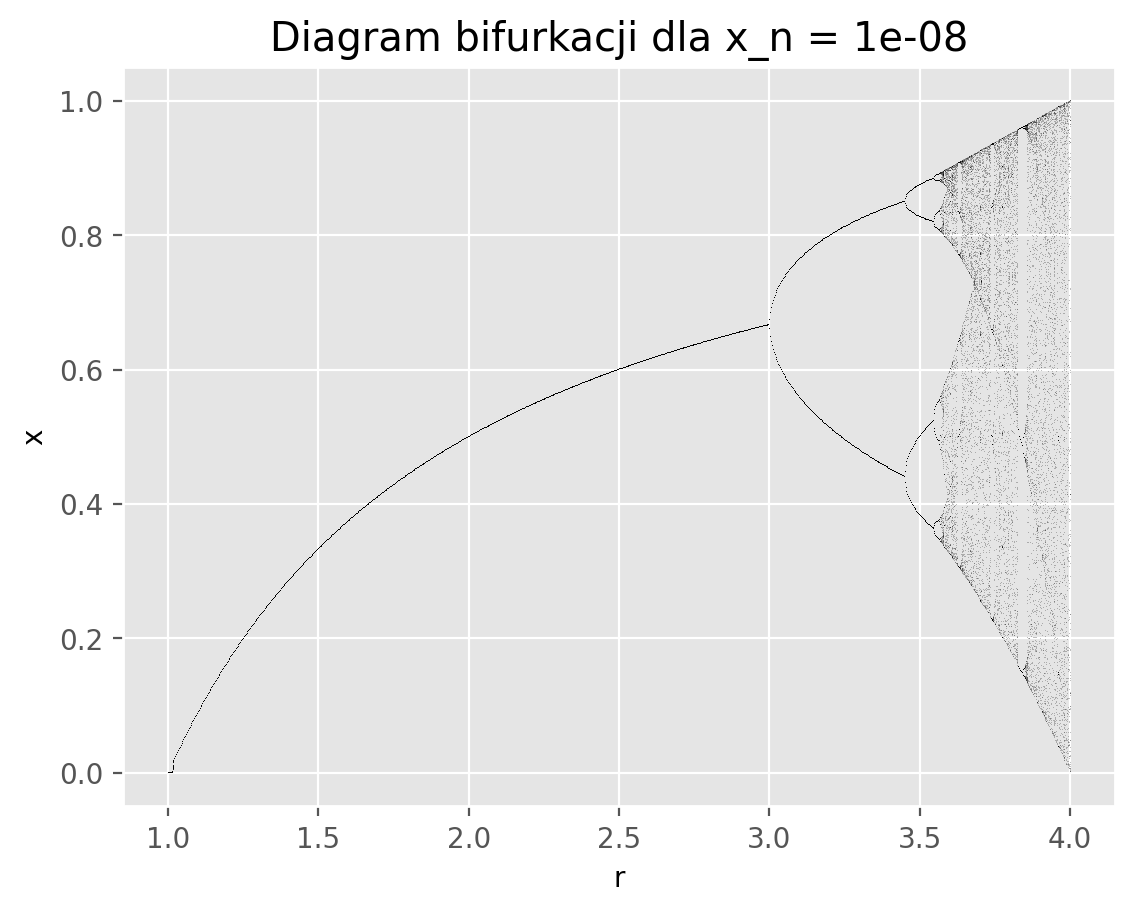

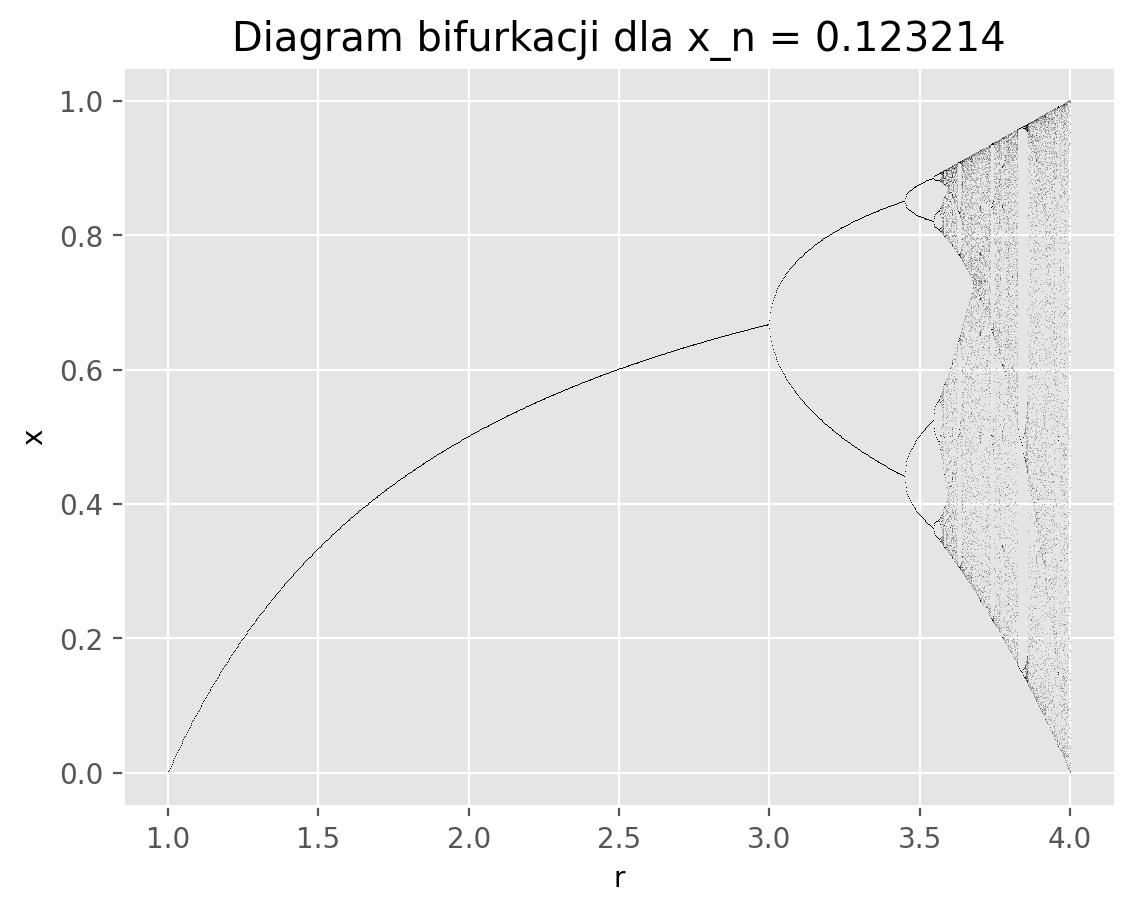

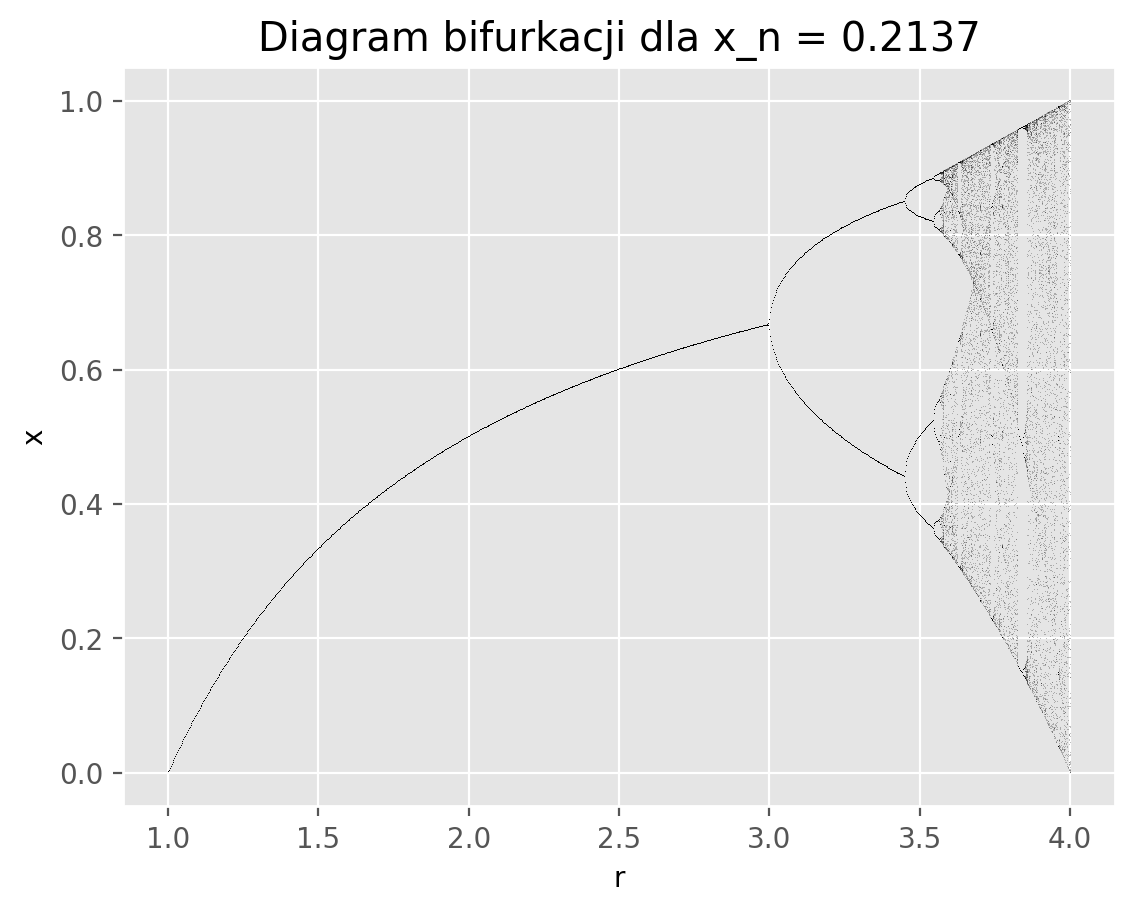

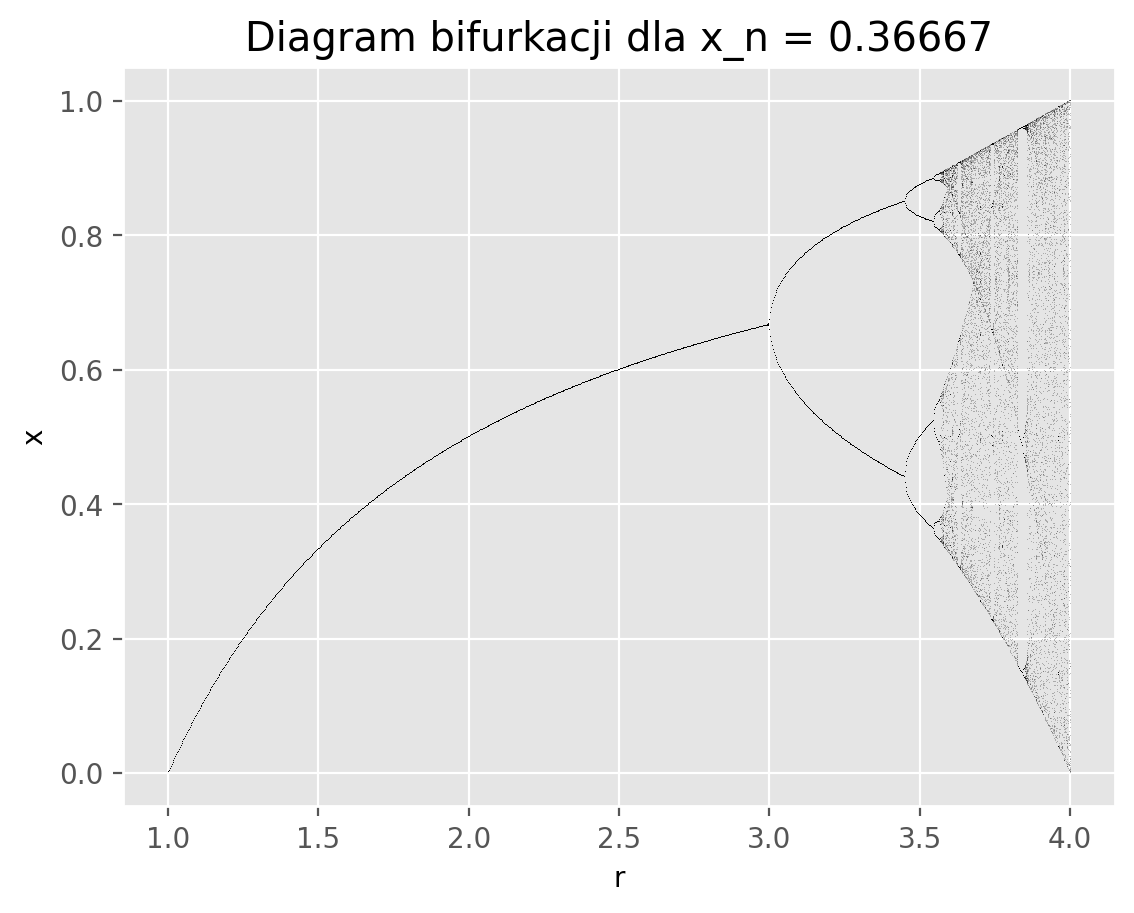

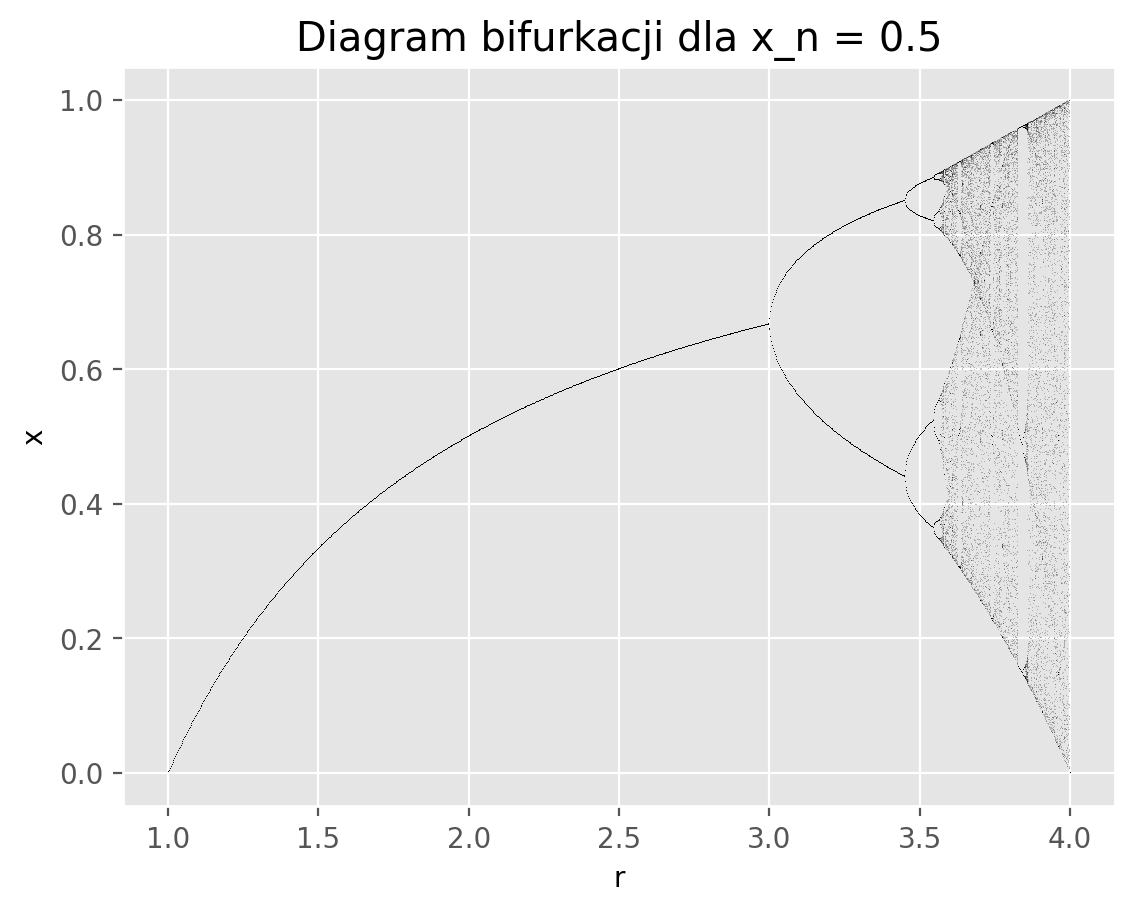

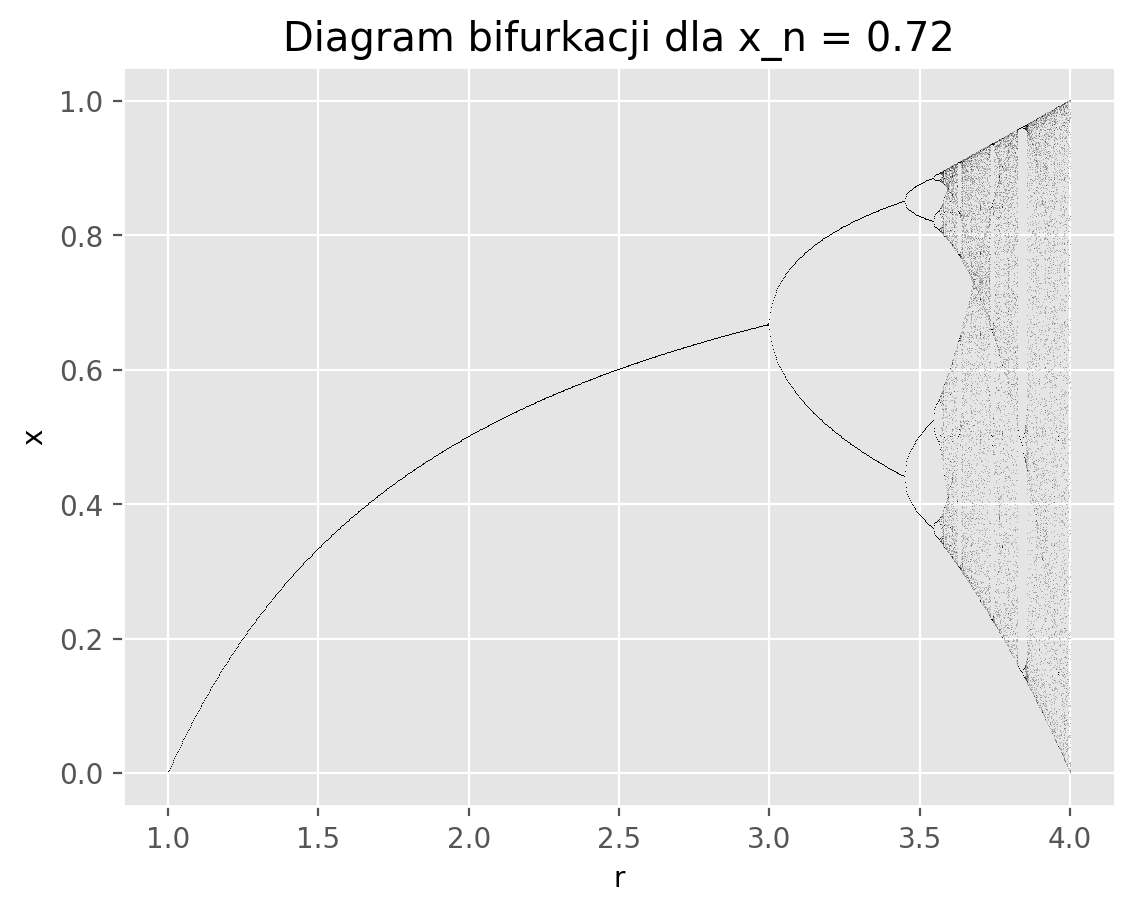

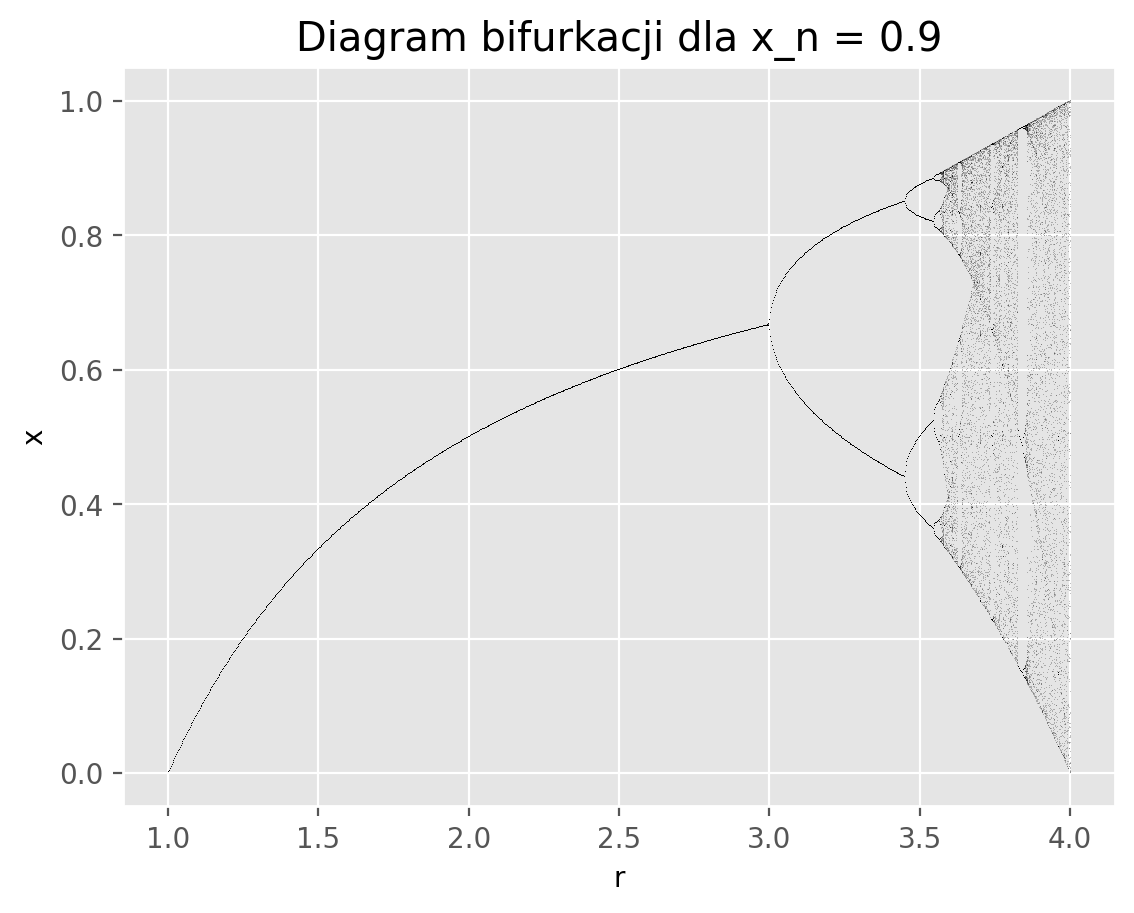

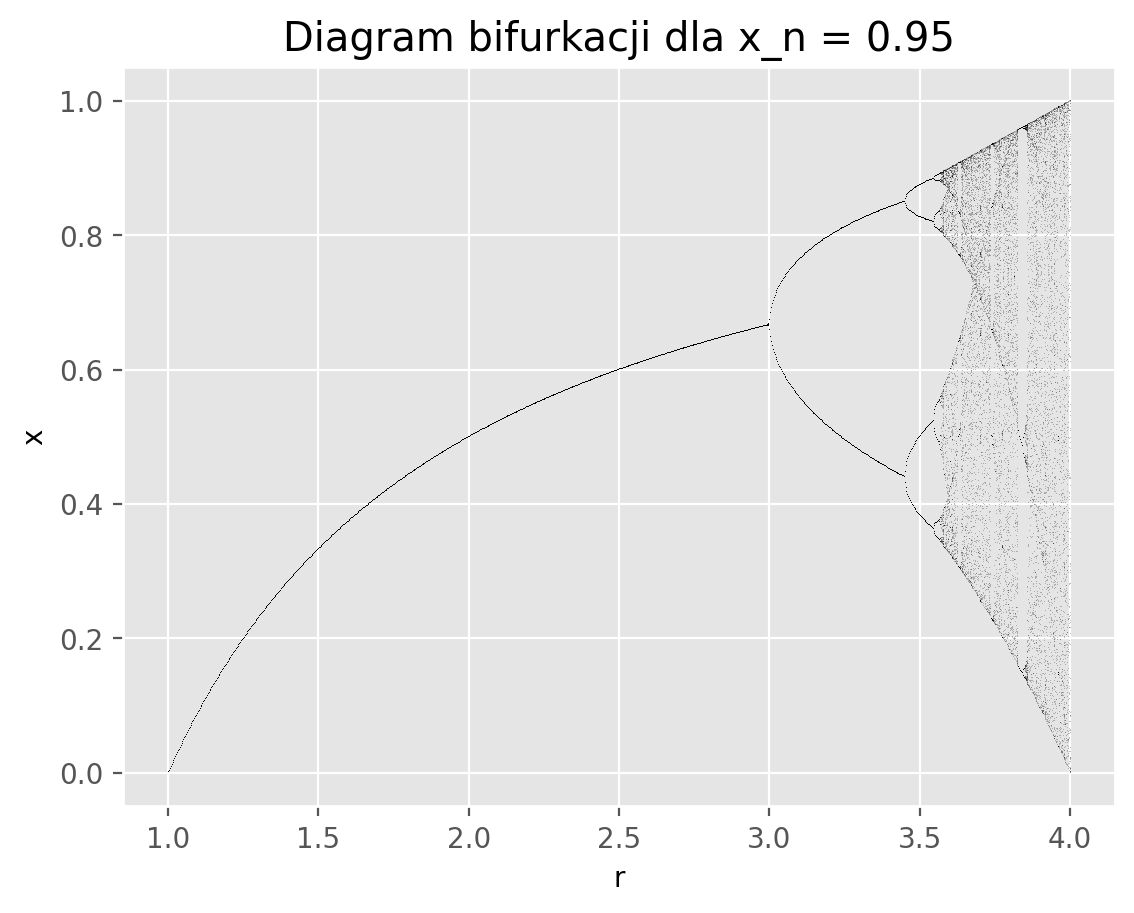

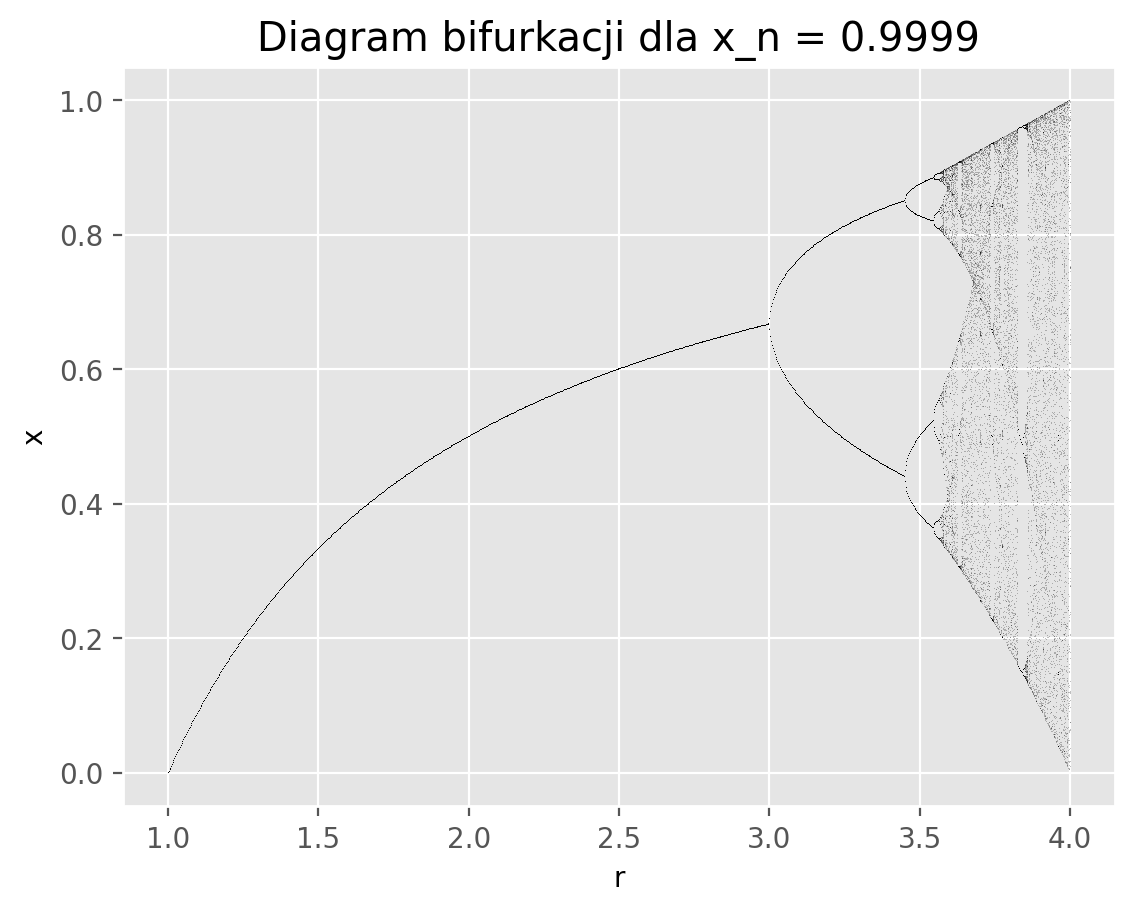

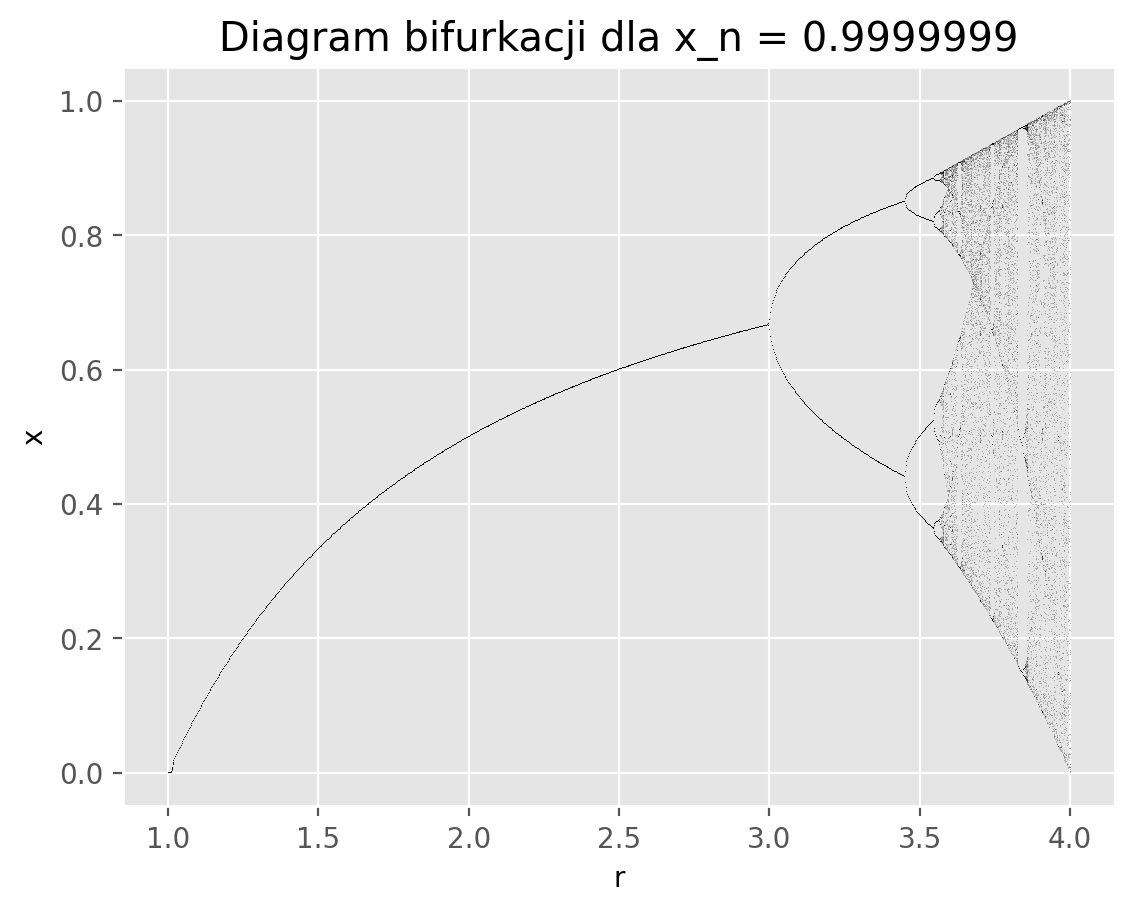

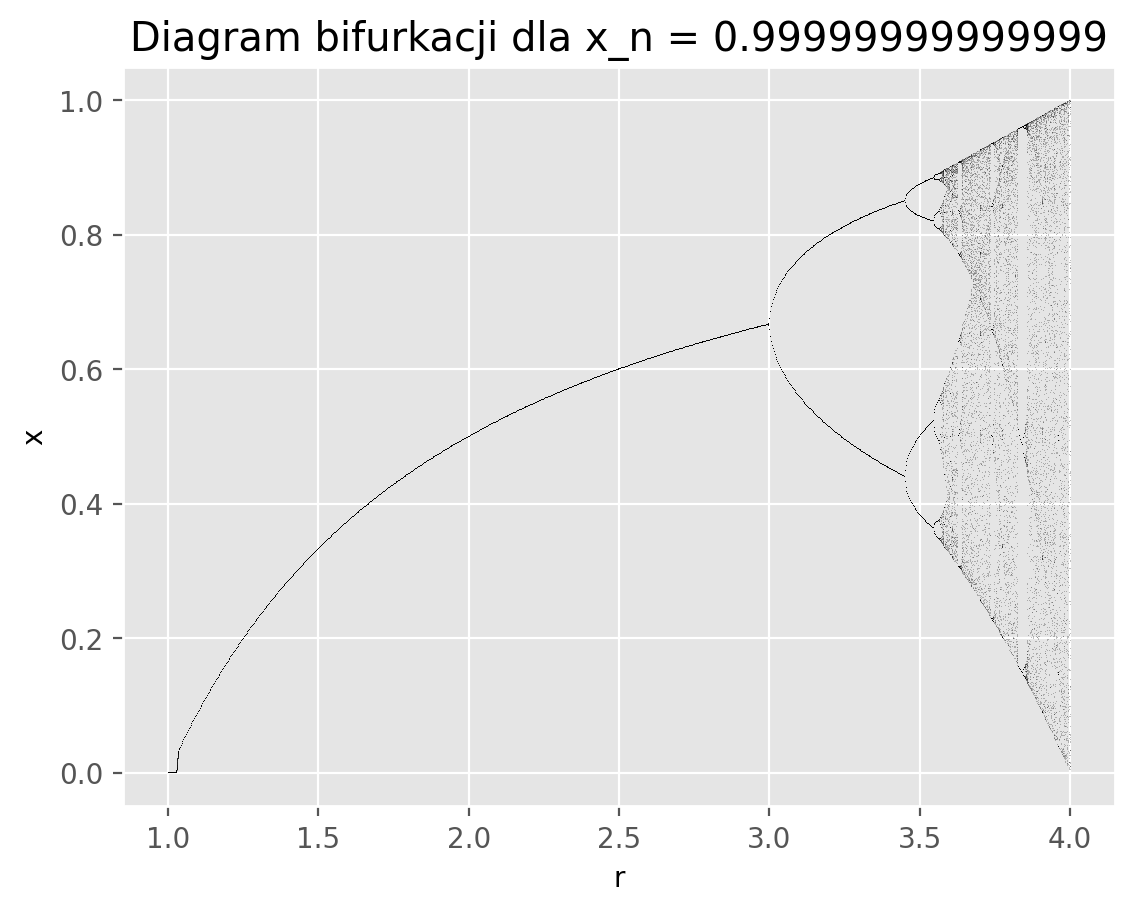

In [17]:
r = np.linspace(1, 4, 1000)

for x_n in x_values:
    draw_diagram(x_n, r)

Z powyższych wykresów można wywnioskować, że do wartości $r$ równej ok. 3.0 odwzorowanie jest niemalejące. Dla większych wartości odwzorowanie zaczyna się "chaos", który ma podobny wygląd dla wszystkich badanych wartości $x_n$. Dla wartości $x_n$ bliżej jedynki oraz zera, początkowy człon odwzorowania zaczyna "rosnąć szybciej", niż dla innych wartości $x_n$.

### Trajektorie

In [18]:
def draw_trajectory(r, x_n, n_iter, x_lim_start):
    x_arr = []
    x_arr_float32 = []

    x_i = x_n
    x_i_float32 = np.float32(x_n)

    for _ in range(n_iter):
        x_i = logistic_function(r, x_i) 
        x_i_float32 = logistic_function_float32(r, x_i_float32)
        x_arr.append(x_i)
        x_arr_float32.append(x_i_float32)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f"Trajektoria dla x_n = {x_n}")
    fig.set_size_inches(10, 5)
    ax1.plot(x_arr)
    ax1.set_xlim(x_lim_start, n_iter)
    ax1.set_xlabel("n")
    ax1.set_ylabel("x")
    ax1.set_title("Float64")
    ax2.plot(x_arr_float32)
    ax2.set_xlim(x_lim_start, n_iter)
    ax2.set_xlabel("n")
    ax2.set_ylabel("x")
    ax2.set_title("Float32")
    plt.show()

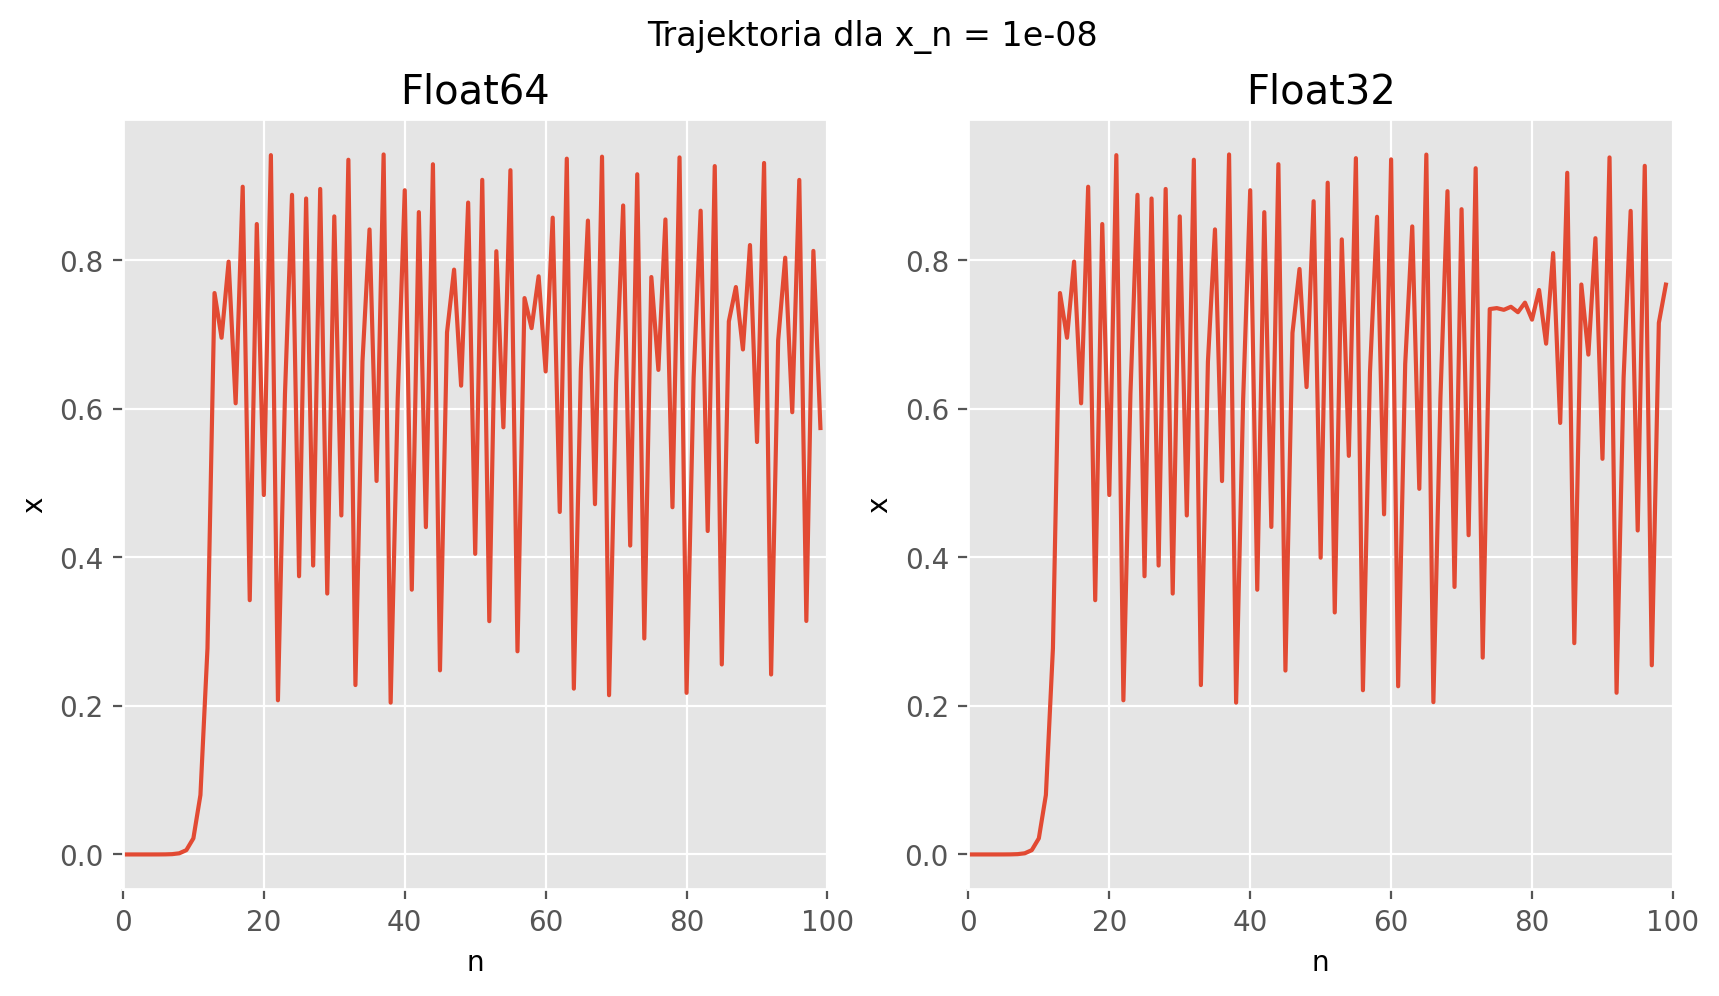

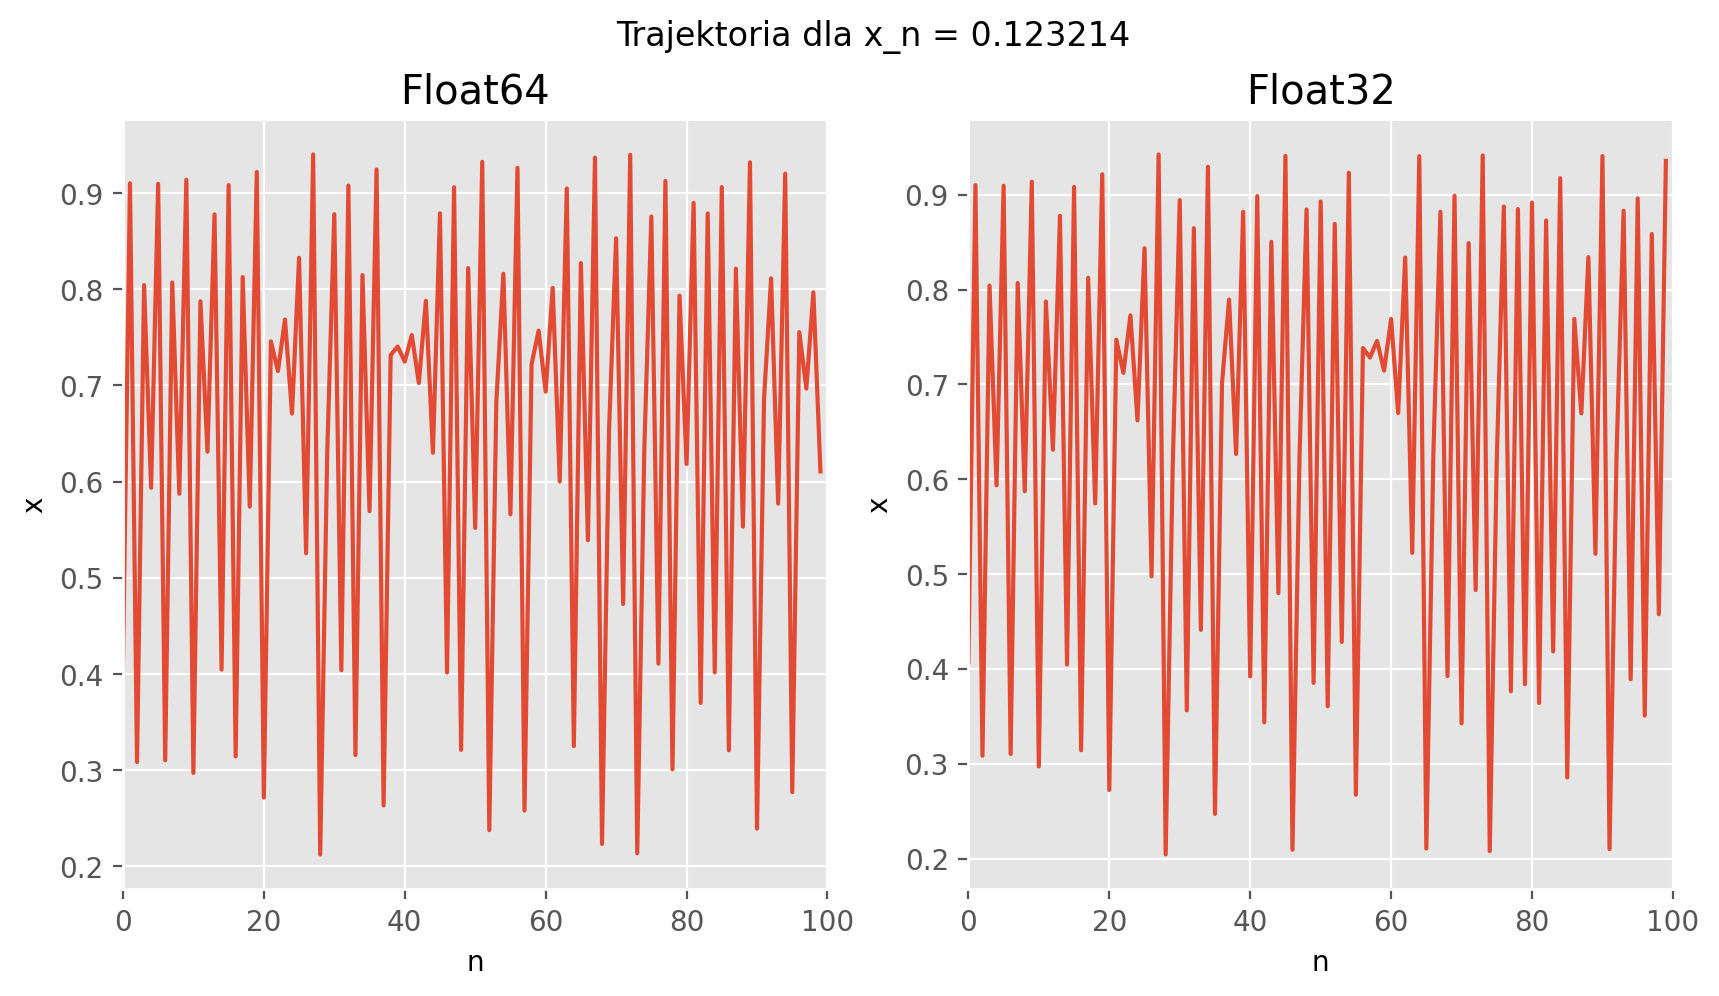

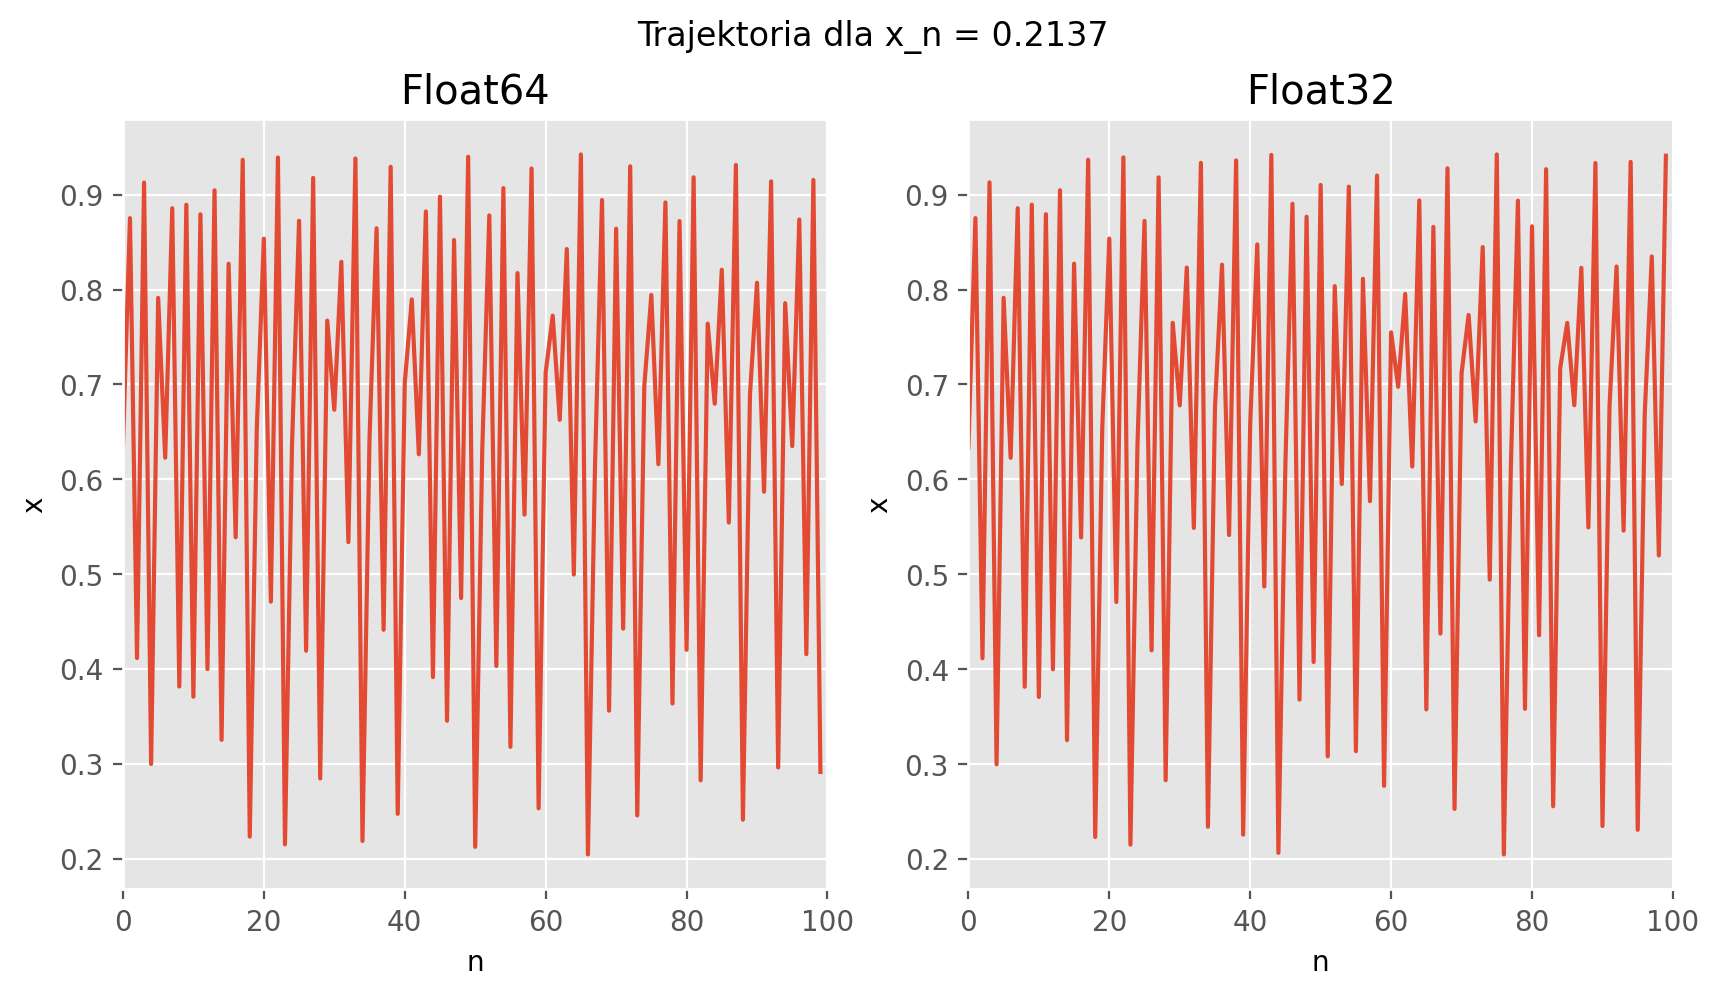

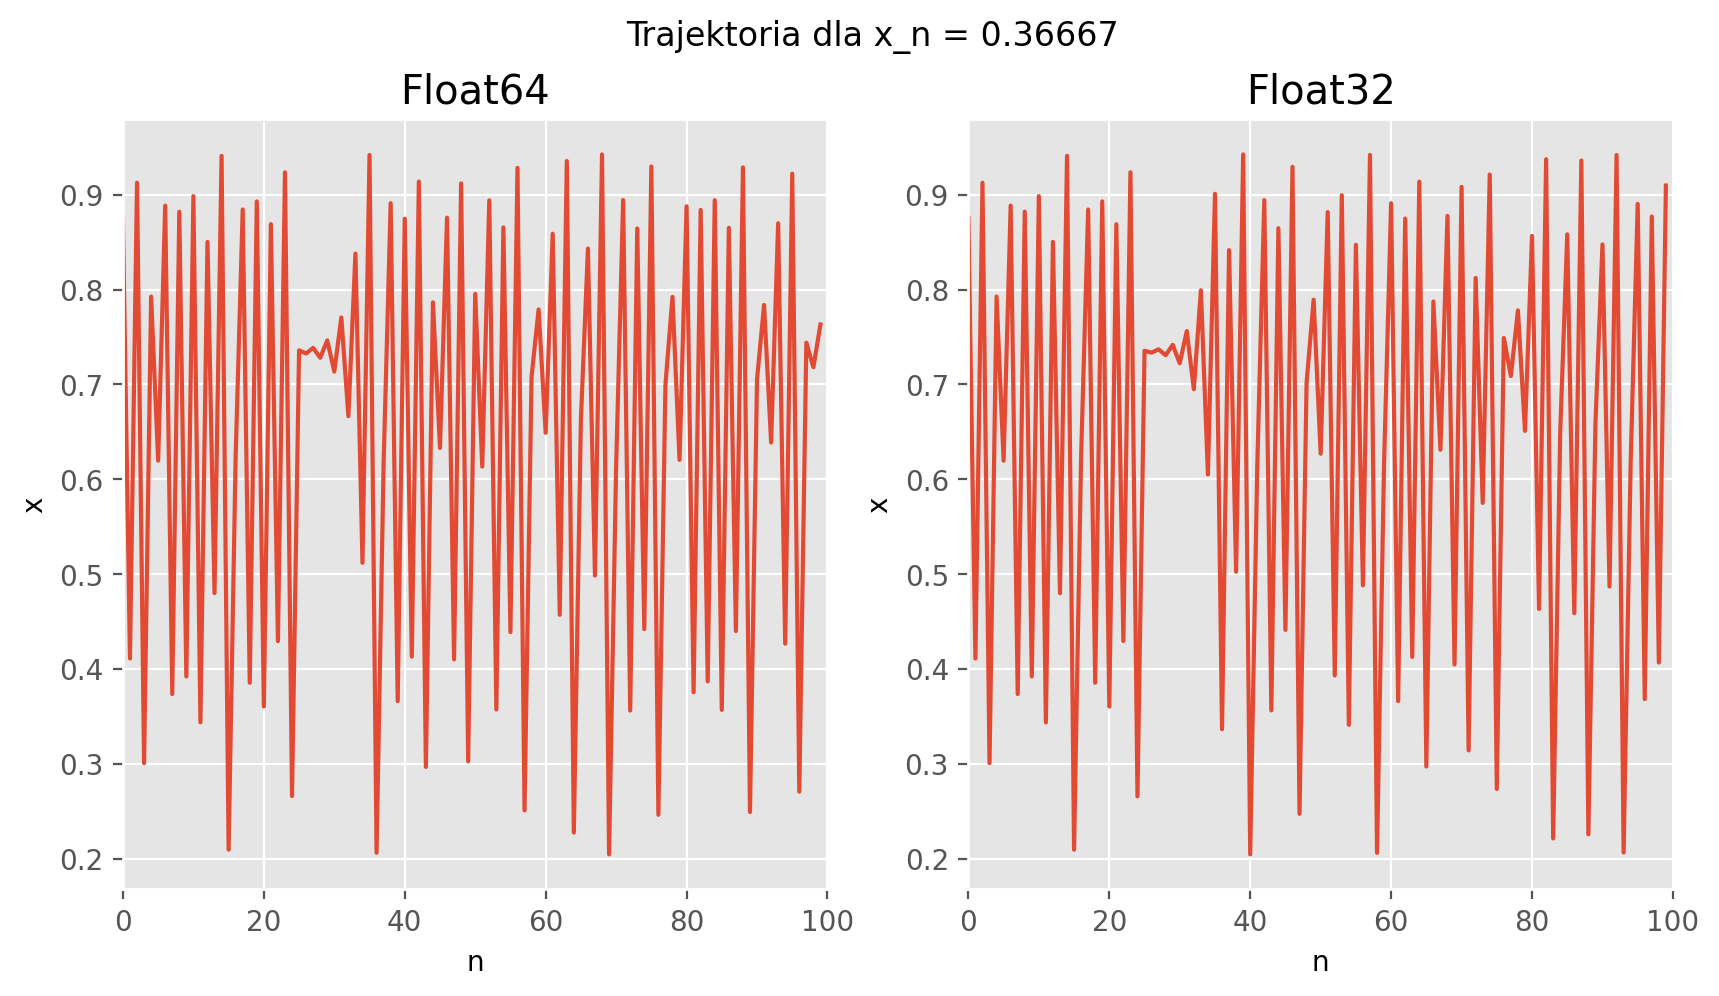

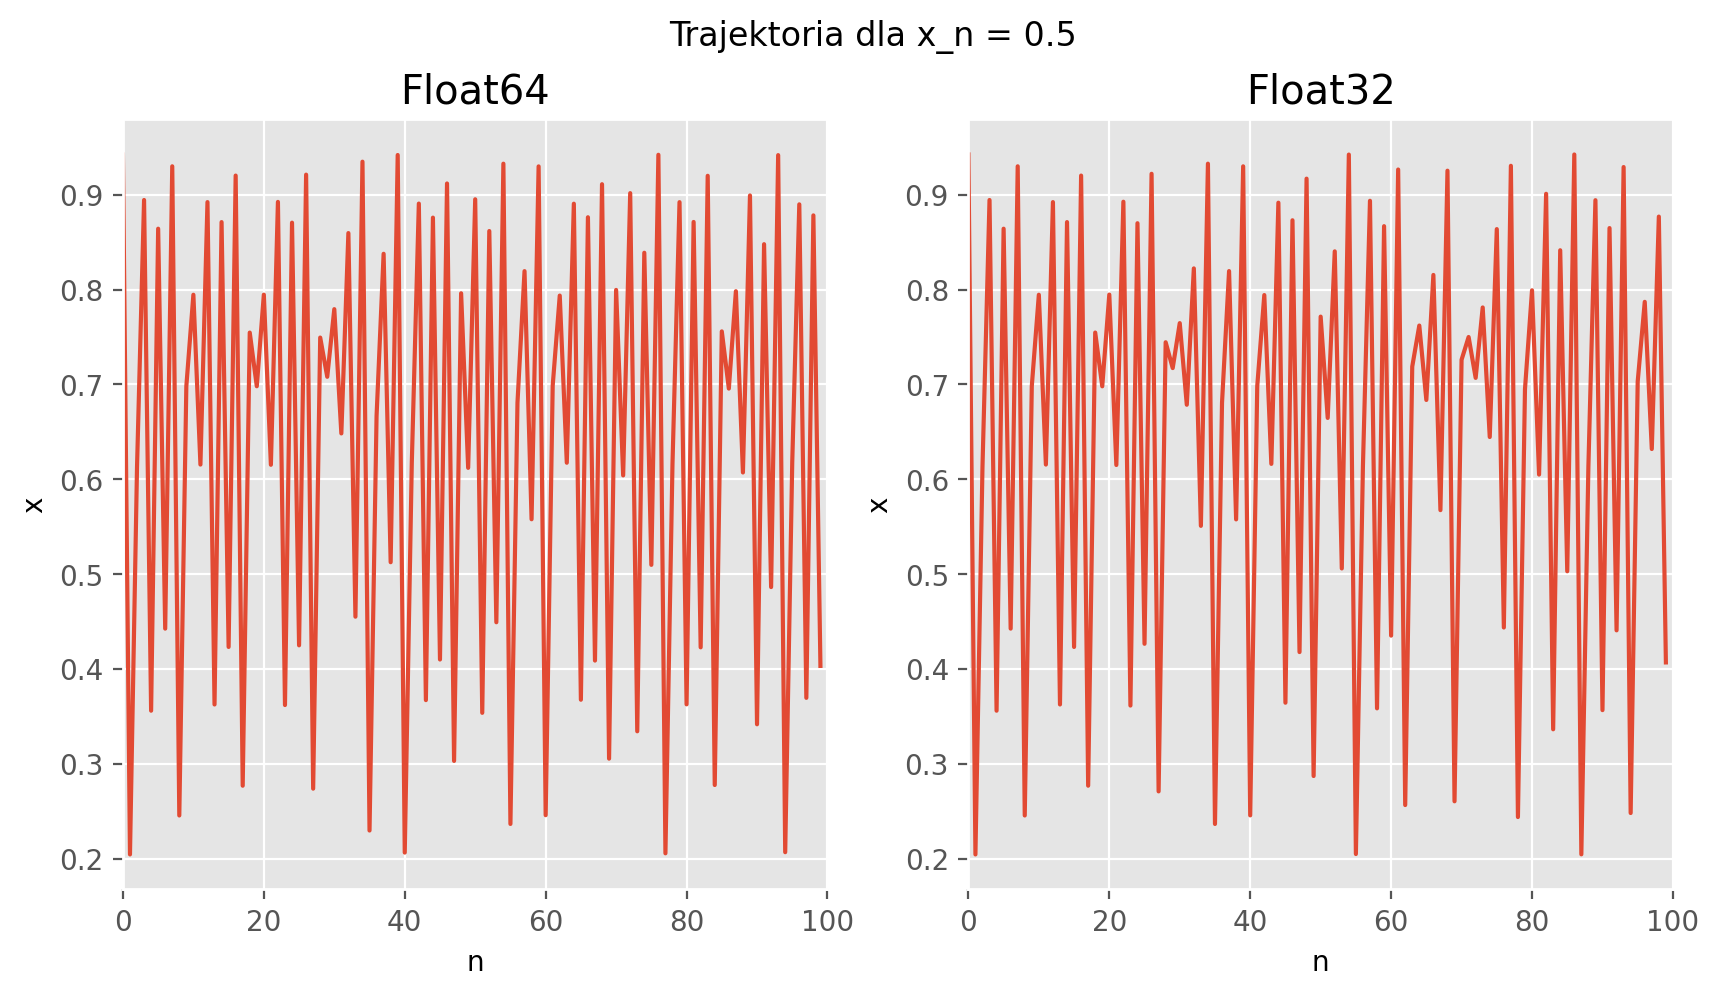

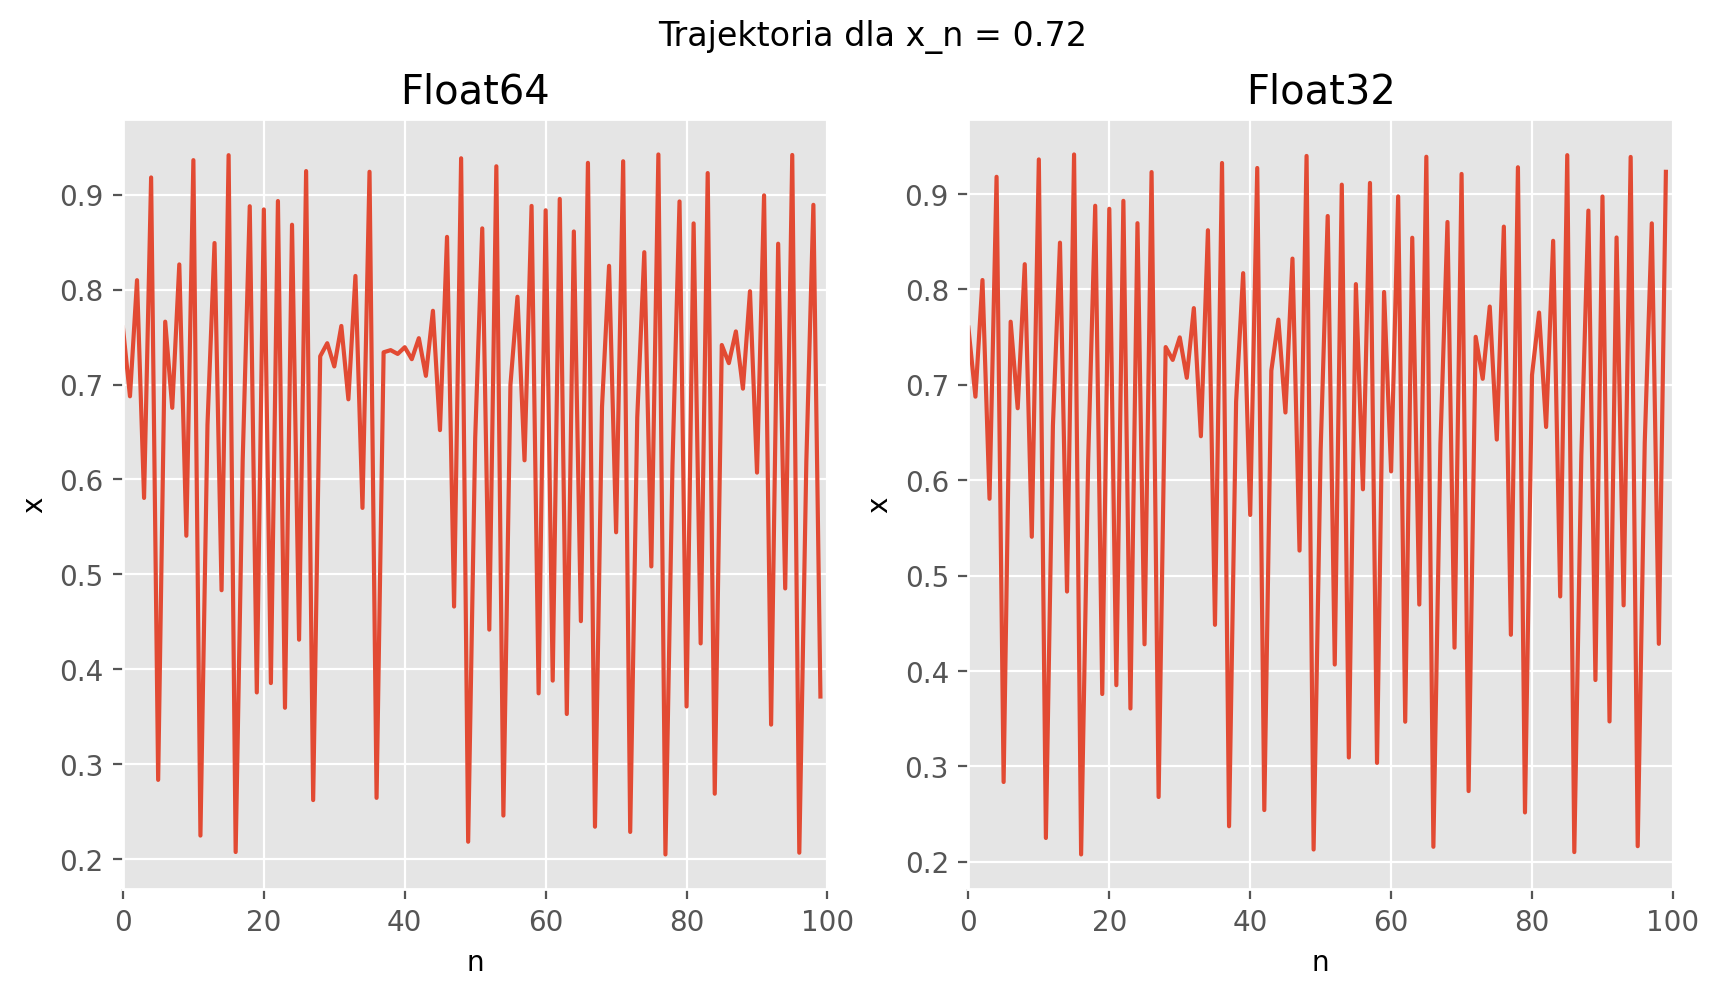

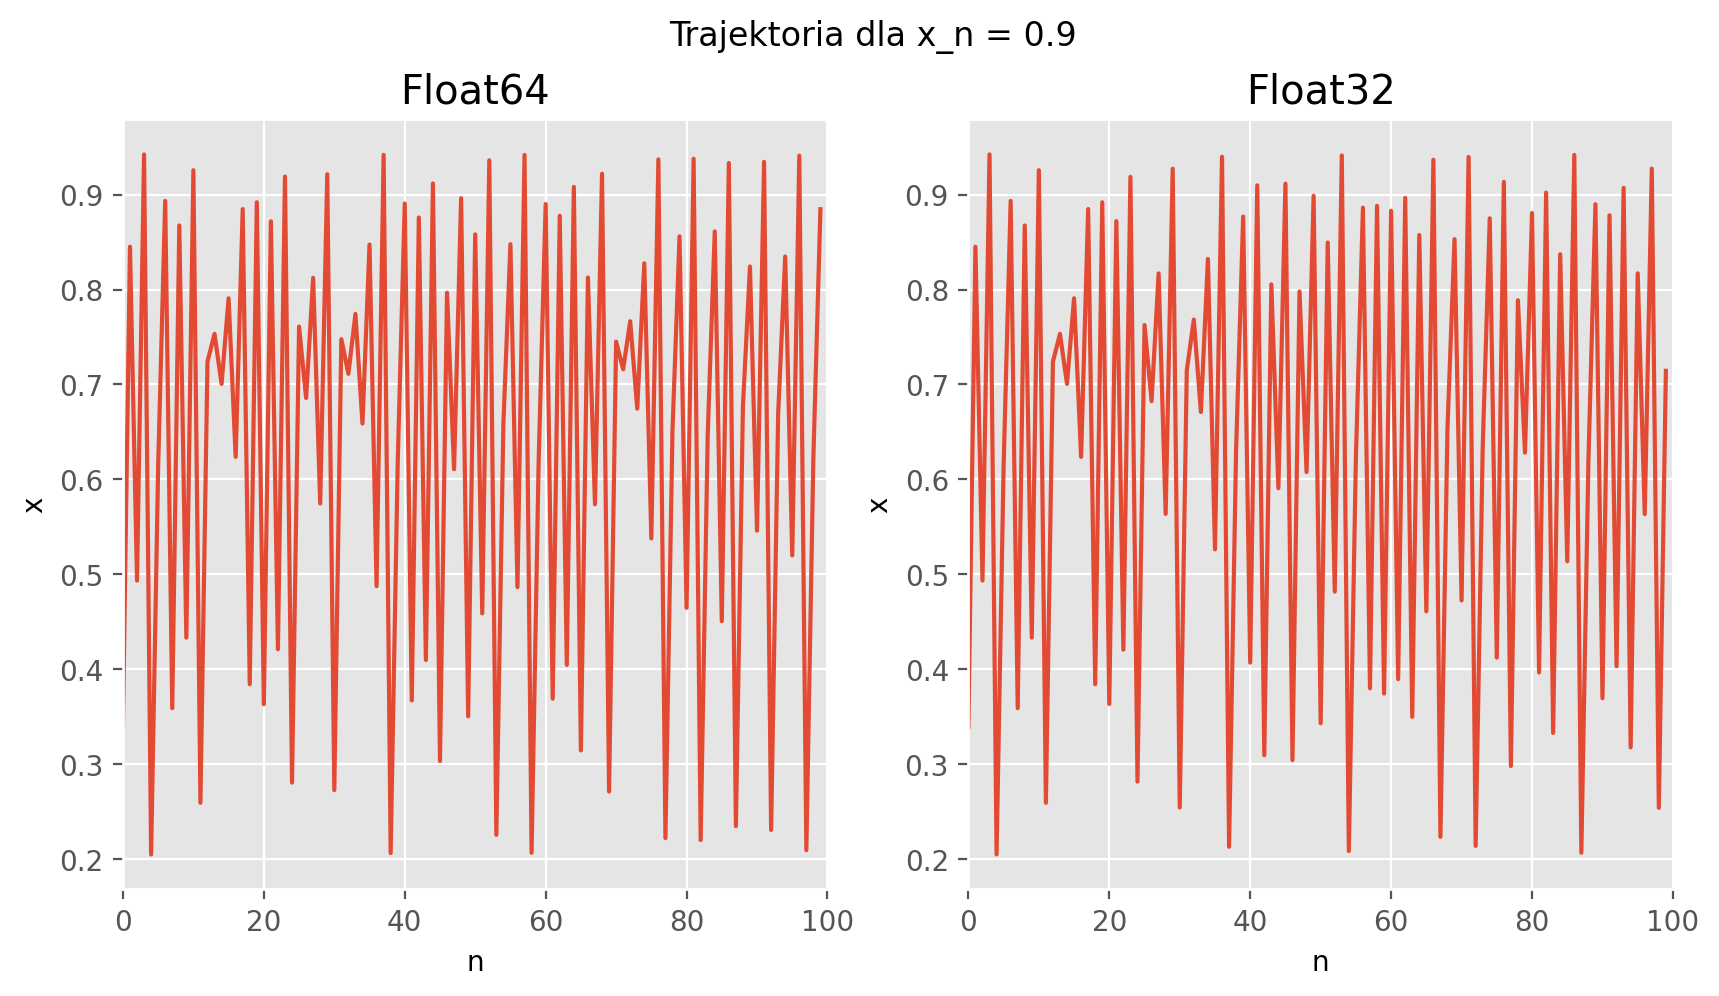

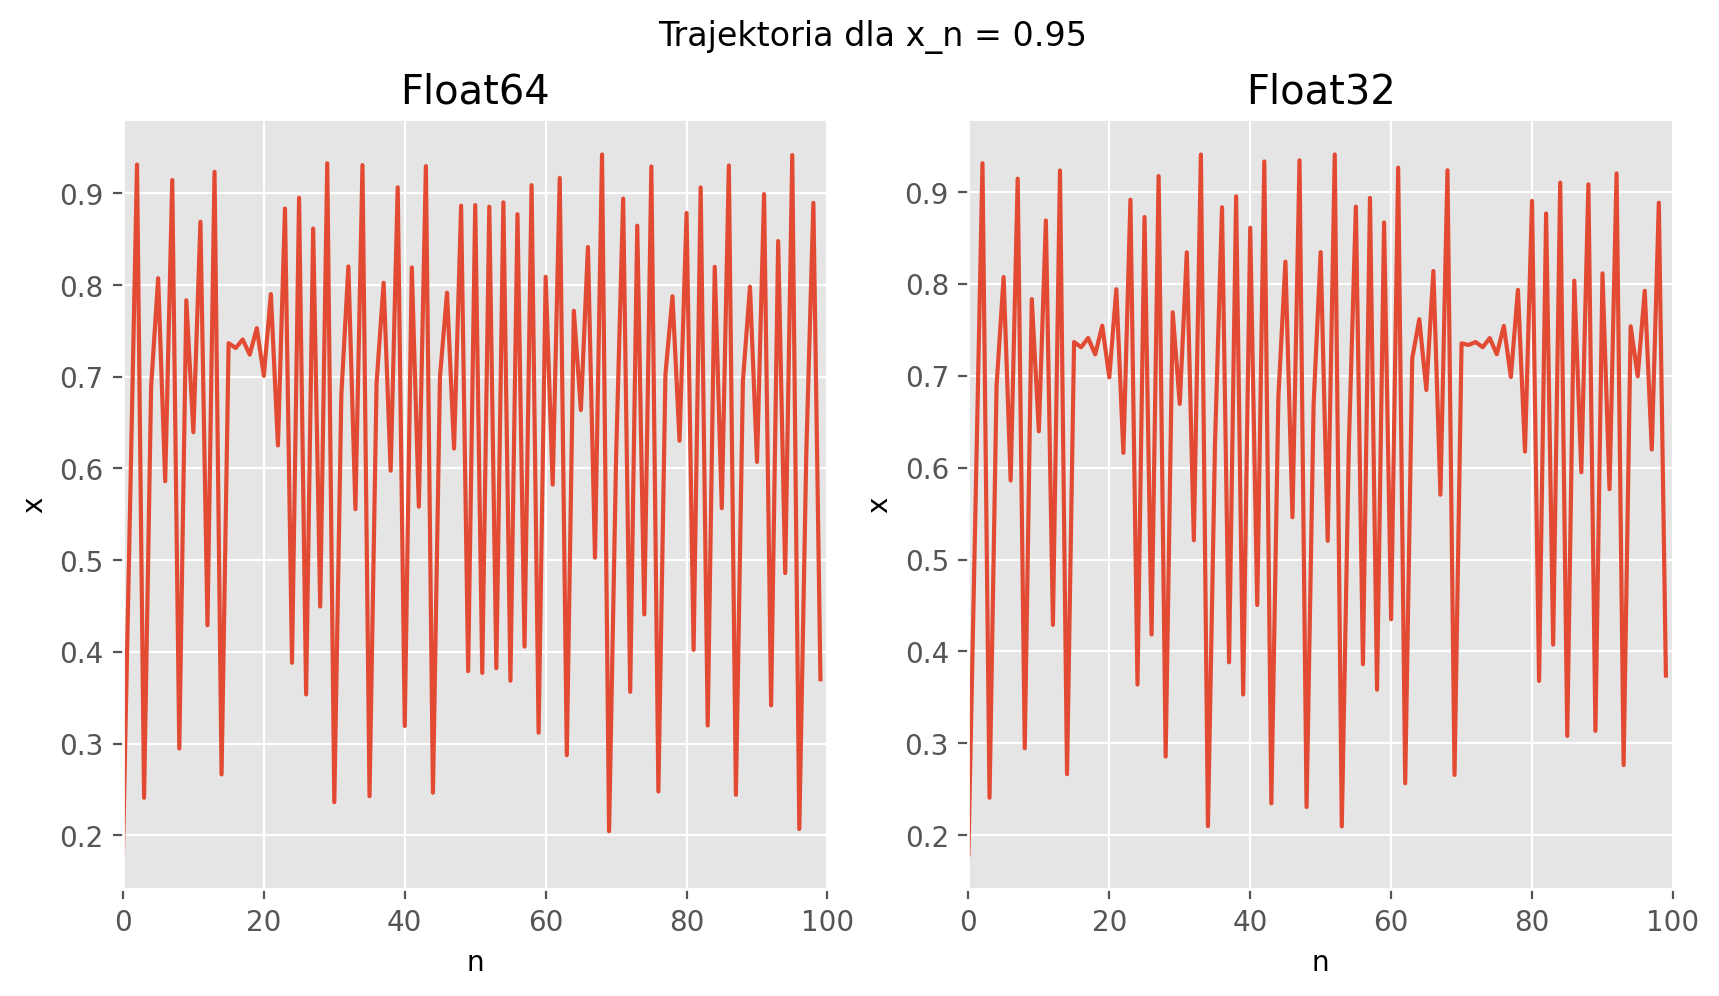

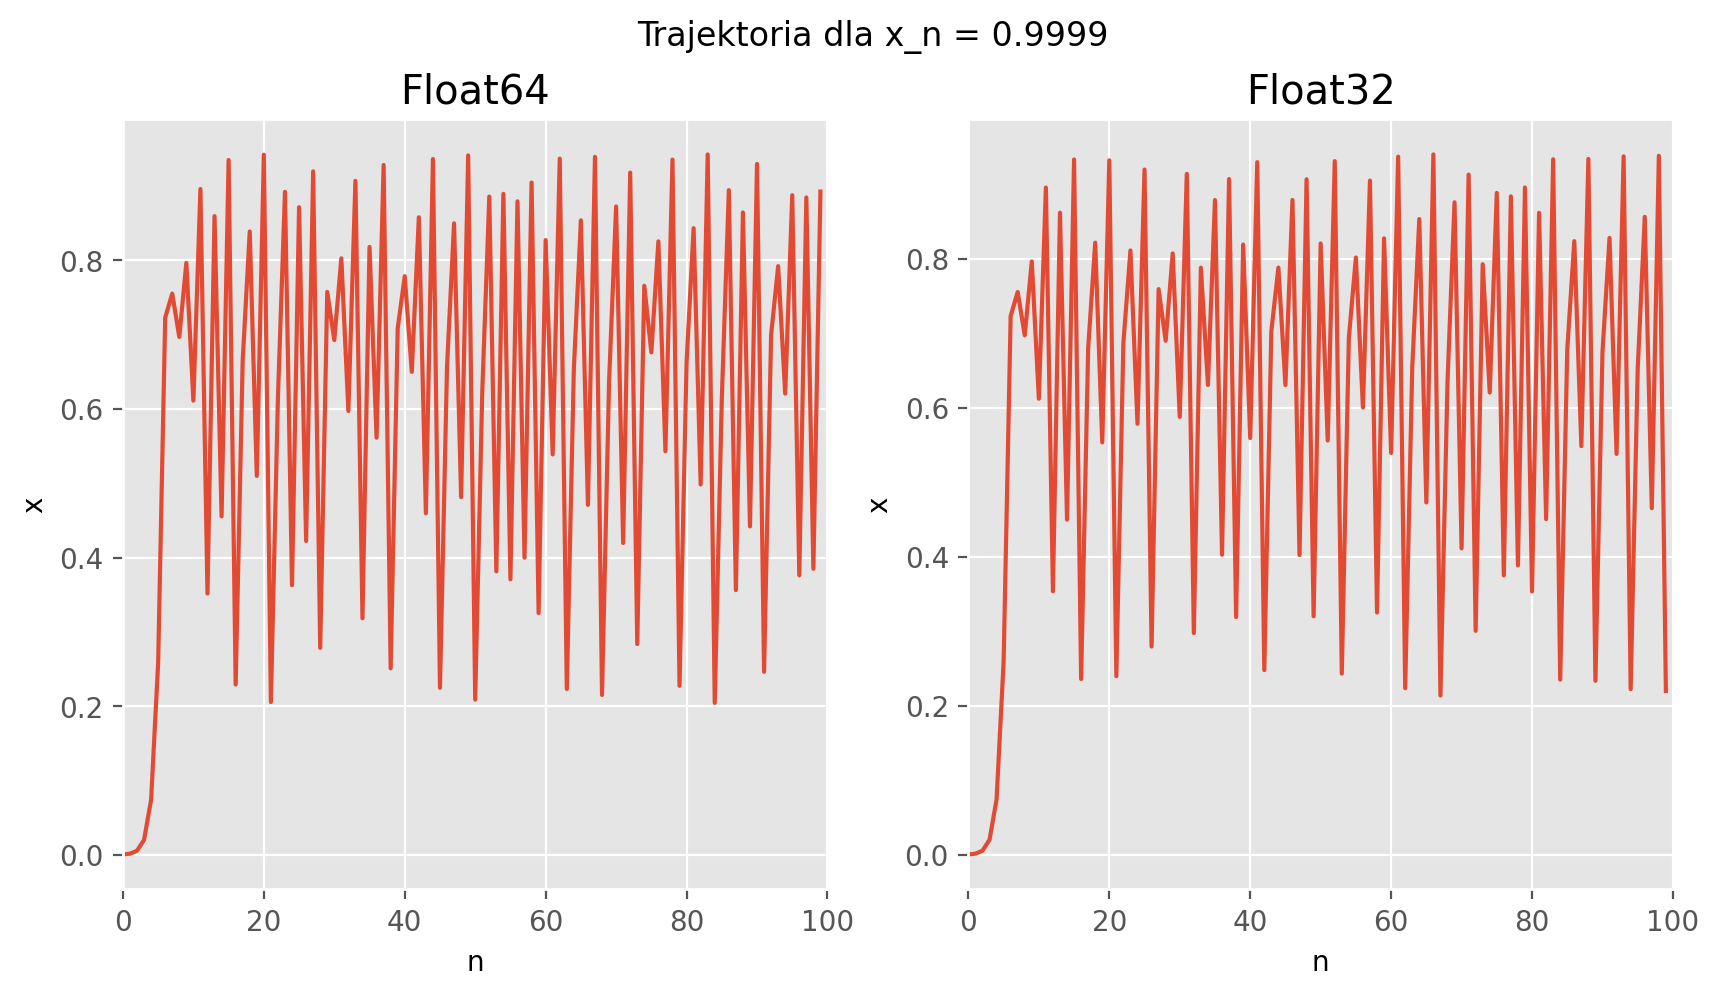

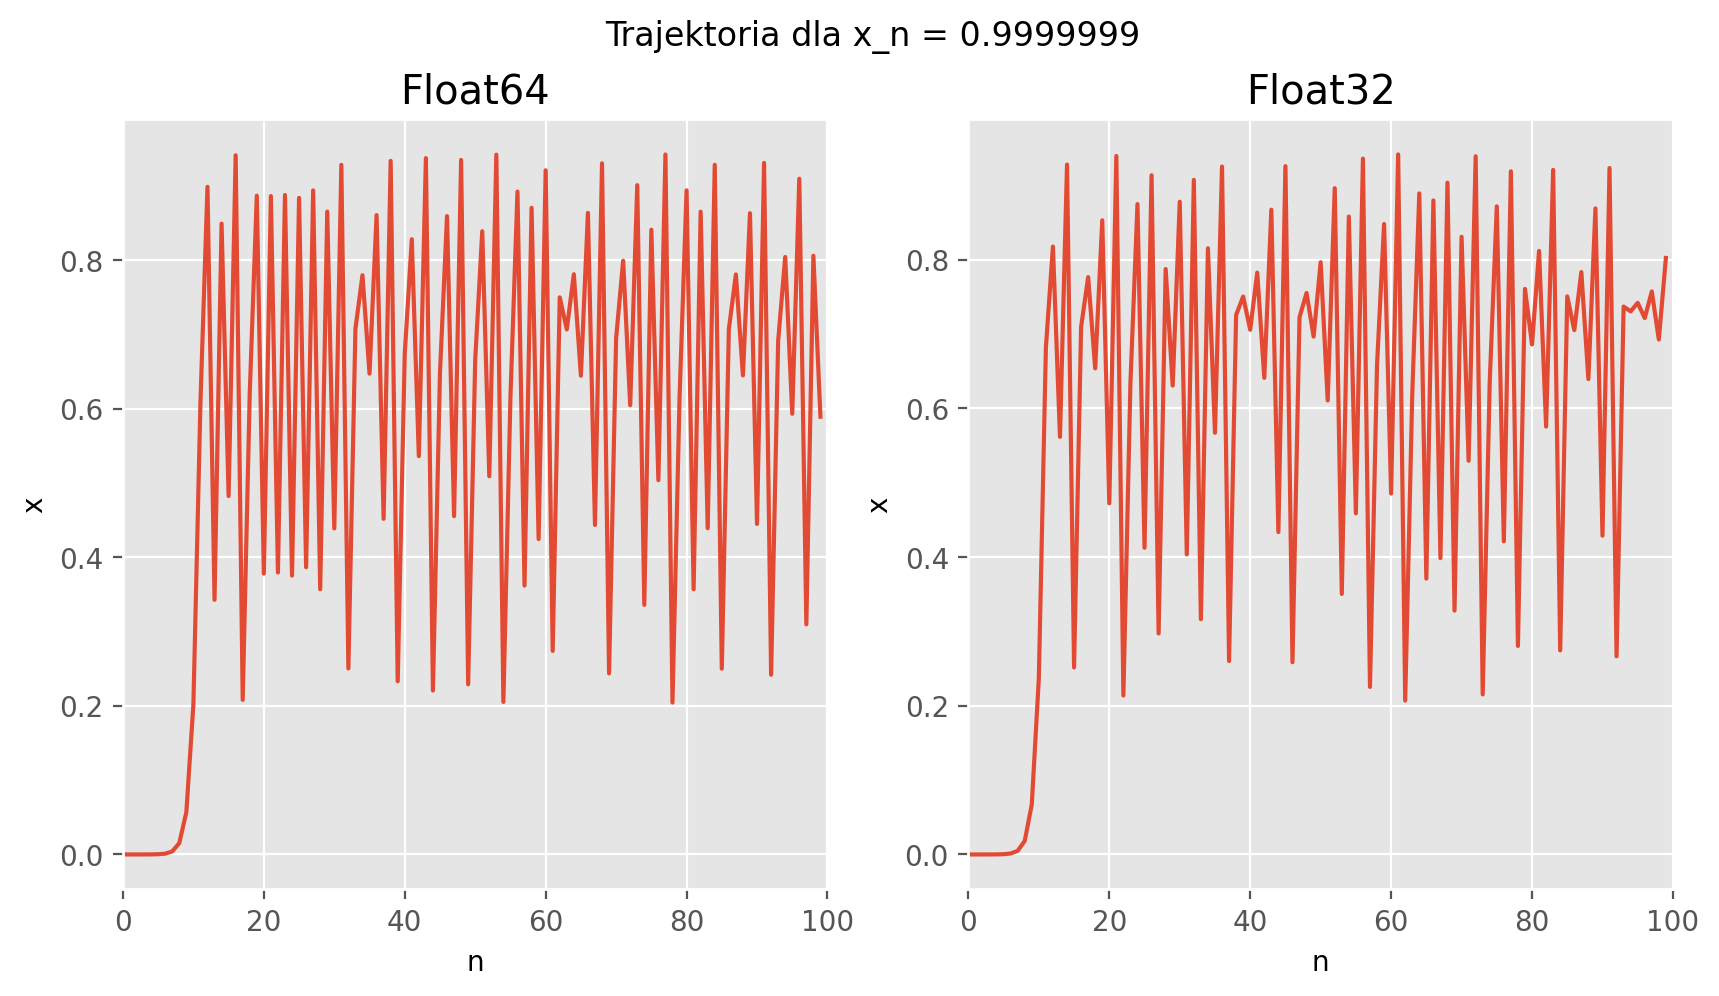

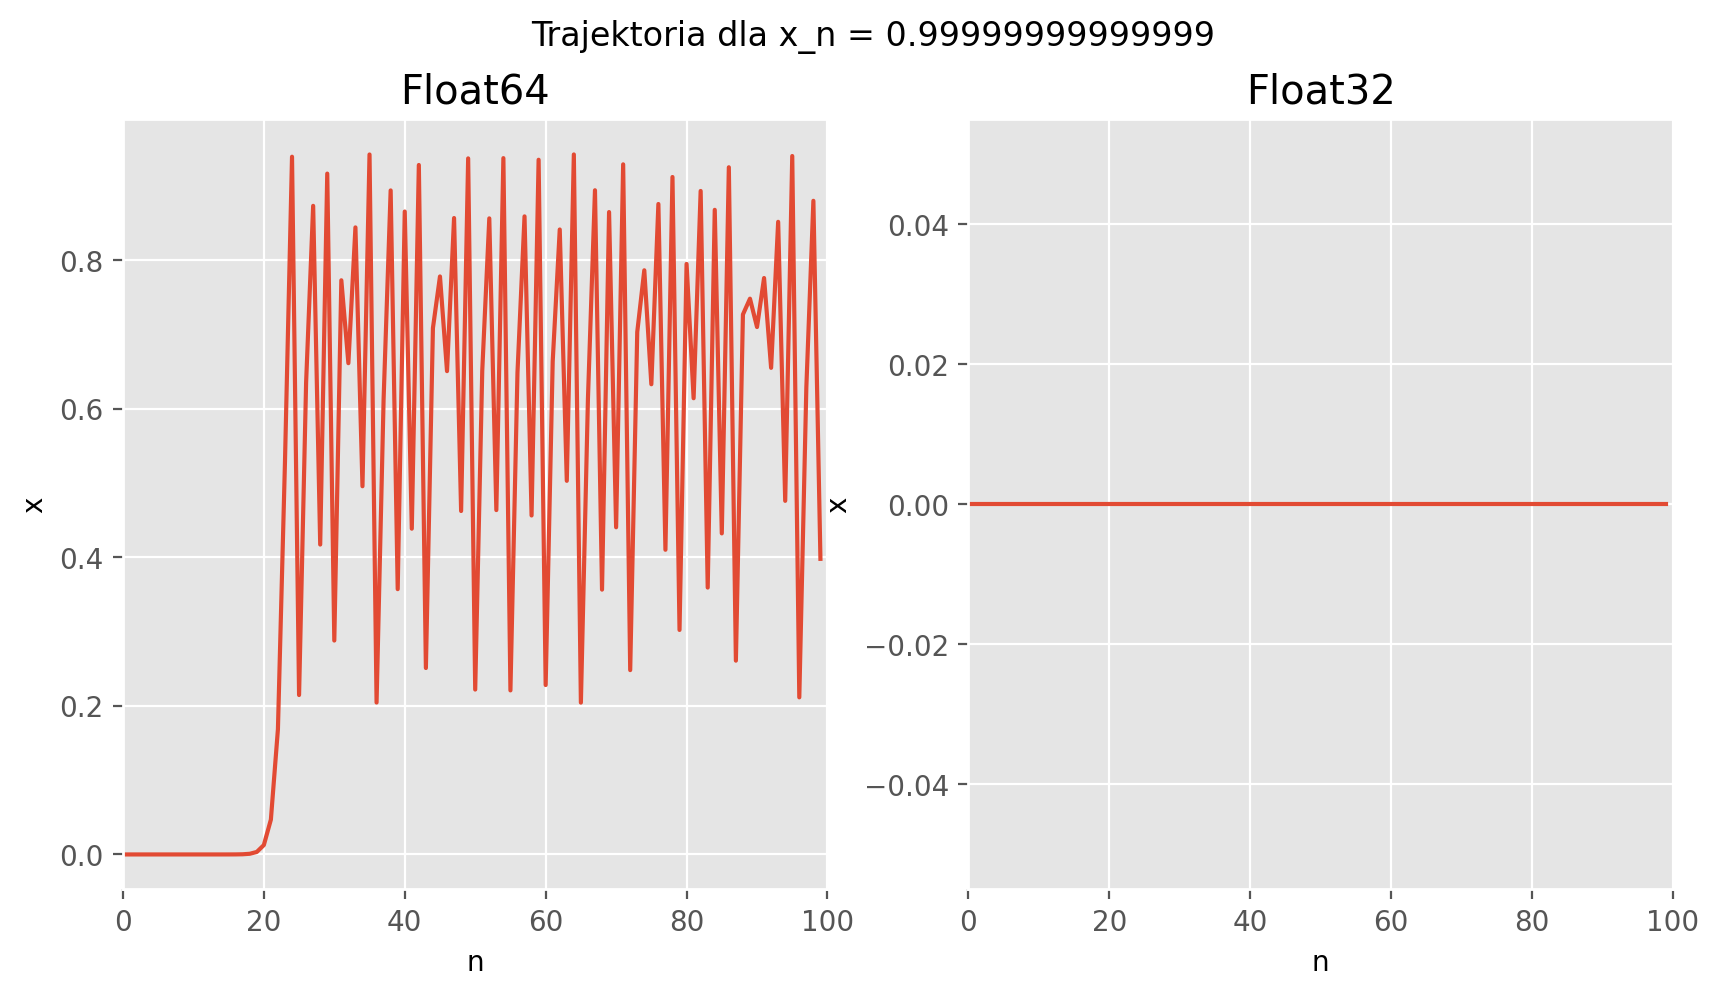

In [19]:
r = 3.77
N = 100

for x_n in x_values:
    draw_trajectory(r, x_n, N, x_lim_start=0)

Dla wartości $r = 3.77$ trajektoria jest bardzo podobna dla pojedynczej jak i podwójnej precyzji. W niektórych miejscach wykresu, podwójna precyzja obliczała wartości nieco większe od pojedynczej (bardziej dokładne), co można zauważyć w mniejszej ilości występowania punktów odległych blisko siebie. Również ciekawy jest przypadek ostatni, gdy dla pojedynczej precyzji wykres przyjął wartość stałą, jest to prawdopodobnie spowodowane dużą wartością x_n, która przekracza typowe wartości precyzji pojedynczej.  

### Liczba iteracji potrzebnych do osiągnięcia zera

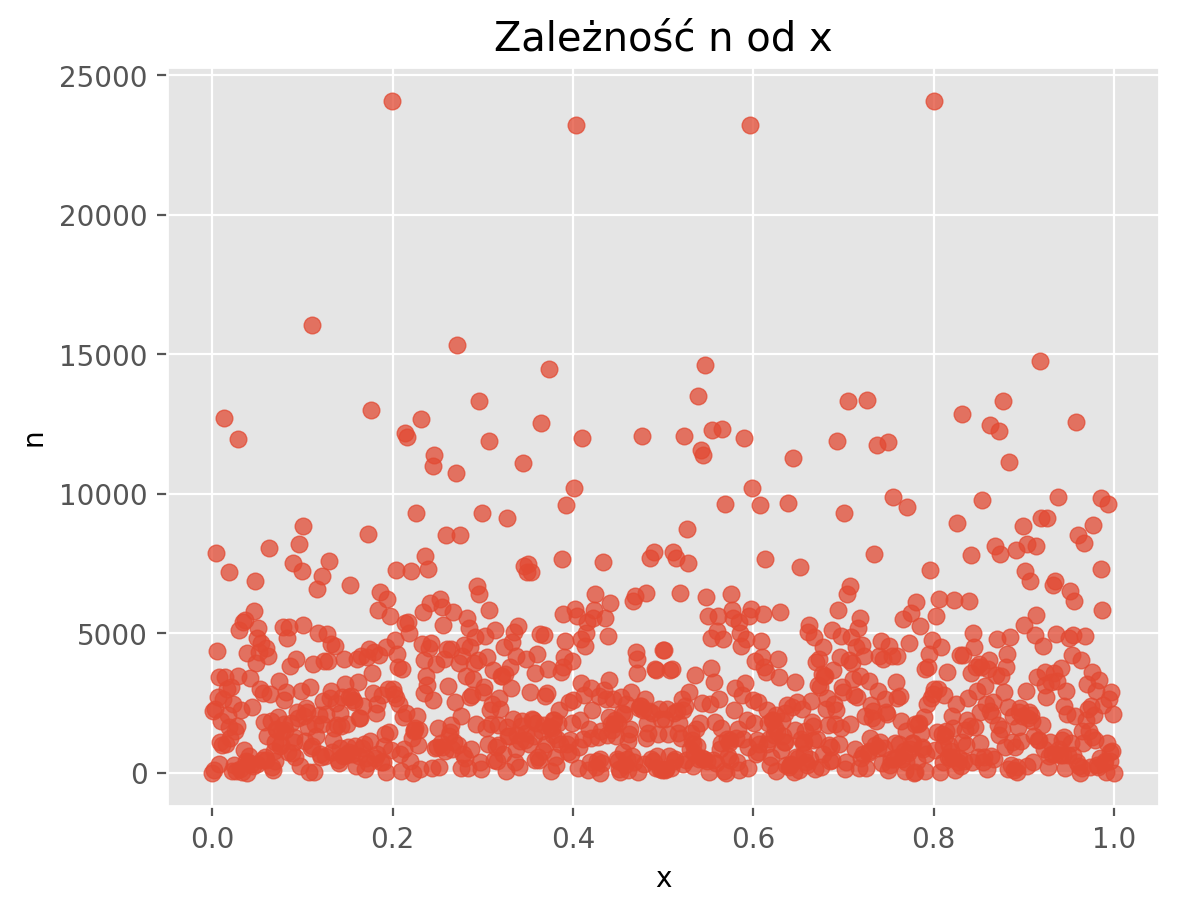

In [20]:
r = 4
epsilon = 1e-6

def find_n(x_n):
    n = 1
    x_i = np.float32(x_n)
    while x_i > epsilon:
        x_i = logistic_function(r, x_i)
        n += 1

    return n

x_n = np.linspace(0, 1, 1000)

plt.title("Zależność n od x")
plt.xlabel("x")
plt.ylabel("n")
plt.scatter(x_n, [find_n(x) for x in x_n], alpha=0.75)
plt.show()


Przedstawiony wykres powyżej przedstawia liczbę iteracji potrzebnych do osiągnięcia zera dla $r$ równego 4 i różnego $x_n \in [0,1]$. Na wykresie widać pewien schemat rozłożenia punktów, który powtarza się co wartość 0.2 na osi opisującej $x_n$. Dla liczb w pobliżu $x_n = 0.2*k$ ($k$ - liczba całkowita), wartości $n$ przyjmują największe wartości. Większość wartości $x_n$ nie przekracza liczby 5000 iteracji.